In [1]:
!pip install yfinance
!pip install statsmodels

In [2]:
!pip install pandas
!pip install numpy
!pip install seaborn

In [3]:
import time
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk")

In [4]:
# ---------------------------------------------------------------------------
# Helper Function: Download Price Data
# ---------------------------------------------------------------------------
def download_price_data(ticker_list, start_date="2018-01-01", end_date=None, interval="1d"):
    """
    Download adjusted close price data for a list of tickers from Yahoo Finance.
    If the returned DataFrame has a MultiIndex, extract each ticker's "Adj Close".
    """
    data = yf.download(ticker_list, start=start_date, end=end_date,
                       interval=interval, group_by="ticker", auto_adjust=False)
    all_prices = pd.DataFrame()
    # Check if the DataFrame has a MultiIndex for columns
    if isinstance(data.columns, pd.MultiIndex):
        for tkr in ticker_list:
            try:
                # Extract "Adj Close" for each ticker
                adj_close = data[tkr]["Adj Close"].rename(tkr)
            except Exception as e:
                print(f"Error with ticker {tkr}: {e}")
                continue
            all_prices = pd.concat([all_prices, adj_close], axis=1)
    else:
        # If a single ticker is downloaded (no MultiIndex)
        try:
            all_prices = data["Adj Close"].to_frame()
            all_prices.columns = ticker_list
        except Exception as e:
            print("Error: 'Adj Close' column not found.", e)
    all_prices.dropna(how="all", inplace=True)
    return all_prices



In [5]:
# ---------------------------------------------------------------------------
# Helper Function: Compute Daily Returns (%)
# ---------------------------------------------------------------------------
def compute_daily_returns(price_df):
    rets = price_df.pct_change() * 100.0
    rets.dropna(inplace=True)
    return rets



In [6]:
# ---------------------------------------------------------------------------
# Helper Function: Summary Statistics & Correlation Heatmap
# ---------------------------------------------------------------------------
def summarize_returns(rets):
    desc = pd.DataFrame({
        "Mean (%)": rets.mean(),
        "Std (%)": rets.std(),
        "Skew": rets.skew(),
        "Kurtosis": rets.kurt()
    })
    return desc

def plot_correlation_heatmap(rets, title="Correlation Heatmap"):
    plt.figure(figsize=(12,8))
    sns.heatmap(rets.corr(), annot=False, cmap="viridis")
    plt.title(title)
    plt.show()


In [7]:
# ---------------------------------------------------------------------------
# Helper Function: CAPM Regression vs. Market (S&P 500)
# ---------------------------------------------------------------------------
def run_capm_regression(returns_df, market_series, rf=0.0):
    results = {}
    common_index = returns_df.index.intersection(market_series.index)
    for col in returns_df.columns:
        y = returns_df.loc[common_index, col] - rf
        x = market_series.loc[common_index] - rf
        df_temp = pd.DataFrame({"y": y, "x": x}).dropna()
        if df_temp.empty:
            continue
        Y = df_temp["y"]
        X_reg = sm.add_constant(df_temp["x"])
        model = sm.OLS(Y, X_reg).fit()
        results[col] = {
            "alpha": model.params["const"],
            "beta": model.params["x"],
            "alpha_t": model.tvalues["const"],
            "beta_t": model.tvalues["x"],
            "R2": model.rsquared
        }
    return pd.DataFrame(results).T


In [8]:
# ---------------------------------------------------------------------------
# Helper Function: Fama–French 3-Factor Regression (Demo)
# ---------------------------------------------------------------------------
def run_fama_french_3factor(returns_df, ff_df):
    results = {}
    common_index = returns_df.index.intersection(ff_df.index)
    for col in returns_df.columns:
        stock_ret = returns_df.loc[common_index, col]
        df_temp = pd.concat([stock_ret, ff_df.loc[common_index]], axis=1).dropna()
        if df_temp.empty:
            continue
        y_excess = df_temp[col] - df_temp["RF"]
        X_f = pd.DataFrame({
            "MKT": df_temp["MKT"],
            "SMB": df_temp["SMB"],
            "HML": df_temp["HML"]
        })
        X_f = sm.add_constant(X_f)
        model = sm.OLS(y_excess, X_f).fit()
        results[col] = {
            "alpha": model.params["const"],
            "b_mkt": model.params["MKT"],
            "b_smb": model.params["SMB"],
            "b_hml": model.params["HML"],
            "alpha_t": model.tvalues["const"],
            "b_mkt_t": model.tvalues["MKT"],
            "b_smb_t": model.tvalues["SMB"],
            "b_hml_t": model.tvalues["HML"],
            "R2": model.rsquared
        }
    return pd.DataFrame(results).T

In [9]:
# ---------------------------------------------------------------------------
# Helper Function: Fit AR(1) Model for Each Ticker
# ---------------------------------------------------------------------------
def fit_ar1_model(returns_df):
    from statsmodels.tsa.ar_model import AutoReg
    results = {}
    for col in returns_df.columns:
        ts = returns_df[col].dropna()
        if len(ts) < 30:
            continue
        model = AutoReg(ts, lags=1, old_names=False).fit()
        results[col] = {
            "intercept": model.params["const"],
            "phi": model.params["y.L1"],
            "t_const": model.tvalues["const"],
            "t_phi": model.tvalues["y.L1"],
            "AIC": model.aic,
            "BIC": model.bic
        }
    return pd.DataFrame(results).T


In [10]:
import yfinance as yf
import time
import pandas as pd

# Revised EV ticker list (using our existing list)
ev_tickers = [
    "TSLA",    # Tesla, Inc.
    "BYDDY",   # BYD Company Limited ADR
    "LI",      # Li Auto Inc.
    "NIO",     # NIO Inc.
    "RIVN",    # Rivian Automotive, Inc.
    "LCID",    # Lucid Group, Inc.
    "XPEV",    # XPeng Inc.
    "NKLA",    # Nikola Corporation
    "PSNY",    # Polestar Automotive Holding UK PLC ADR
    "GM",      # General Motors Company
    "F",       # Ford Motor Company
    "VWAGY",   # Volkswagen AG ADR
    "BAMXF",    # Bayerische Motoren Werke AG (BMW)
    "HYMTF",   # Hyundai Motor Company ADR
    "KIMTF",   # Kia Corporation ADR (approximation)
    "POAHY",   # Porsche AG (via Porsche Automobil Holding)
    "MBGYY",   # Mercedes-Benz Group AG ADR
    "STLA",    # Stellantis N.V.
    "GELYF",   # Geely Automobile Holdings Limited ADR
    "GWLLY",   # Great Wall Motor Company Limited ADR
    "SAIC",    # SAIC Motor Corporation Limited (approximation)
    "HYLN",    # Hyliion Holdings
    "GNZUF",   # GAC Group (approximation)
    "TATAMOTORS.NS",  # Tata Motors in India
    "MAHMF",   # Mahindra & Mahindra Limited ADR (approximation)
    "RNLSY",   # Renault Group ADR (approximation)
    "NSANY",   # Nissan Motor Co., Ltd. ADR
    "MMTOF"    # Mitsubishi Motors Corporation
]

# Dictionary to store each ticker's DataFrame separately
ev_data_dict = {}

for ticker in ev_tickers:
    print(f"Downloading data for {ticker}...")
    df = yf.download(ticker, start="2018-01-01", interval="1d", auto_adjust=False)
    if df.empty:
        print(f"Data for {ticker} is empty. Please verify the ticker.")
    else:
        ev_data_dict[ticker] = df
        print(f"Data for {ticker} (first 5 rows):")
        print(df.head())
    print("-" * 80)
    time.sleep(0.5)  


[*********************100%***********************]  1 of 1 completed


Data for TSLA (first 5 rows):
Price       Adj Close      Close       High        Low       Open     Volume
Ticker           TSLA       TSLA       TSLA       TSLA       TSLA       TSLA
Date                                                                        
2018-01-02  21.368668  21.368668  21.474001  20.733334  20.799999   65283000
2018-01-03  21.150000  21.150000  21.683332  21.036667  21.400000   67822500
2018-01-04  20.974667  20.974667  21.236668  20.378668  20.858000  149194500
2018-01-05  21.105333  21.105333  21.149332  20.799999  21.108000   68868000
2018-01-08  22.427334  22.427334  22.468000  21.033333  21.066668  147891000
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed

Data for BYDDY (first 5 rows):
Price       Adj Close      Close       High    Low       Open Volume
Ticker          BYDDY      BYDDY      BYDDY  BYDDY      BYDDY  BYDDY
Date                                                                
2018-01-02  17.250002  17.790001  17.889999  17.67  17.670000  53800
2018-01-03  17.822092  18.379999  18.440001  18.02  18.020000  23100
2018-01-04  17.599072  18.150000  18.370001  18.08  18.129999  29900
2018-01-05  17.414837  17.959999  17.959999  17.75  17.950001  33700
2018-01-08  17.405146  17.950001  18.070000  17.58  17.580000  67400
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed

Data for LI (first 5 rows):
Price       Adj Close      Close   High    Low       Open    Volume
Ticker             LI         LI     LI     LI         LI        LI
Date                                                               
2020-07-30  16.459999  16.459999  17.50  15.10  15.490000  64611300
2020-07-31  16.000000  16.000000  17.17  15.99  16.670000  19532800
2020-08-03  16.360001  16.360001  17.00  15.77  16.260000  11740000
2020-08-04  16.690001  16.690001  16.84  15.95  16.549999   7781800
2020-08-05  16.750000  16.750000  17.00  16.40  16.649000   3991400
--------------------------------------------------------------------------------



[*********************100%***********************]  1 of 1 completed

Data for NIO (first 5 rows):
Price      Adj Close  Close   High   Low   Open     Volume
Ticker           NIO    NIO    NIO   NIO    NIO        NIO
Date                                                      
2018-09-12      6.60   6.60   6.93  5.35   6.00   66849000
2018-09-13     11.60  11.60  12.69  6.52   6.62  158346500
2018-09-14      9.90   9.90  13.80  9.22  12.66  172473600
2018-09-17      8.50   8.50   9.75  8.50   9.61   56323900
2018-09-18      7.68   7.68   9.10  7.67   8.73   41827600
--------------------------------------------------------------------------------



[*********************100%***********************]  1 of 1 completed

Data for RIVN (first 5 rows):
Price        Adj Close       Close        High         Low        Open  \
Ticker            RIVN        RIVN        RIVN        RIVN        RIVN   
Date                                                                     
2021-11-10  100.730003  100.730003  119.459999   95.199997  106.750000   
2021-11-11  122.989998  122.989998  125.000000  108.010002  114.625000   
2021-11-12  129.949997  129.949997  135.199997  125.250000  128.645004   
2021-11-15  149.360001  149.360001  152.529999  127.510002  130.800003   
2021-11-16  172.009995  172.009995  179.470001  153.779999  163.800003   

Price          Volume  
Ticker           RIVN  
Date                   
2021-11-10  103679500  
2021-11-11   83668200  
2021-11-12   50636800  
2021-11-15   64982300  
2021-11-16   94036600  
--------------------------------------------------------------------------------



[*********************100%***********************]  1 of 1 completed

Data for LCID (first 5 rows):
Price      Adj Close Close    High   Low   Open   Volume
Ticker          LCID  LCID    LCID  LCID   LCID     LCID
Date                                                    
2020-09-18      9.89  9.89  10.250  9.82  10.25   564300
2020-09-21      9.86  9.86   9.960  9.86   9.90   762800
2020-09-22      9.88  9.88   9.960  9.85   9.96  1280800
2020-09-23      9.85  9.85   9.905  9.79   9.90   192600
2020-09-24      9.77  9.77   9.850  9.75   9.85   605500
--------------------------------------------------------------------------------



[*********************100%***********************]  1 of 1 completed

Data for XPEV (first 5 rows):
Price       Adj Close      Close       High        Low       Open    Volume
Ticker           XPEV       XPEV       XPEV       XPEV       XPEV      XPEV
Date                                                                       
2020-08-27  21.219999  21.219999  25.000000  21.200001  23.100000  82219700
2020-08-28  22.790001  22.790001  24.400000  22.020000  23.980000  44847300
2020-08-31  20.500000  20.500000  22.790001  20.330000  22.690001  20816000
2020-09-01  21.610001  21.610001  21.790001  20.100000  20.980000  15291400
2020-09-02  21.090000  21.090000  22.000000  20.379999  21.990000   9090100
--------------------------------------------------------------------------------



[*********************100%***********************]  1 of 1 completed

Data for NKLA (first 5 rows):
Price         Adj Close        Close         High          Low         Open  \
Ticker             NKLA         NKLA         NKLA         NKLA         NKLA   
Date                                                                          
2020-06-04  1012.500000  1012.500000  1166.400024   937.500000  1126.500000   
2020-06-05  1079.099976  1079.099976  1079.400024   982.500000  1069.500000   
2020-06-08  2198.100098  2198.100098  2211.000000  1212.599976  1260.000000   
2020-06-09  2391.899902  2391.899902  2819.699951  1709.849976  2793.899902   
2020-06-10  1950.300049  1950.300049  2310.000000  1948.500000  2265.300049   

Price        Volume  
Ticker         NKLA  
Date                 
2020-06-04   552220  
2020-06-05   279559  
2020-06-08  1667622  
2020-06-09  2360423  
2020-06-10   856906  
--------------------------------------------------------------------------------



[*********************100%***********************]  1 of 1 completed

Data for PSNY (first 5 rows):
Price      Adj Close  Close   High    Low   Open Volume
Ticker          PSNY   PSNY   PSNY   PSNY   PSNY   PSNY
Date                                                   
2021-05-18     10.00  10.00  10.00  10.00  10.00    500
2021-05-19      9.78   9.78   9.78   9.78   9.78   1100
2021-05-20      9.76   9.76   9.90   9.72   9.90   2500
2021-05-21      9.76   9.76   9.80   9.76   9.80   5000
2021-05-24      9.76   9.76   9.76   9.76   9.76      0
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed

Data for GM (first 5 rows):
Price       Adj Close      Close       High        Low       Open    Volume
Ticker             GM         GM         GM         GM         GM        GM
Date                                                                       
2018-01-02  37.019329  41.799999  41.869999  41.150002  41.240002   6934600
2018-01-03  37.922668  42.820000  42.950001  42.200001  42.209999  14591600
2018-01-04  39.091694  44.139999  44.250000  43.009998  43.090000  17298700
2018-01-05  38.976570  44.009998  44.639999  43.959999  44.500000   9643300
2018-01-08  39.162552  44.220001  44.590000  43.520000  44.040001  13099600
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


Data for F (first 5 rows):
Price      Adj Close  Close   High    Low   Open    Volume
Ticker             F      F      F      F      F         F
Date                                                      
2018-01-02  8.594530  12.66  12.66  12.50  12.52  20773300
2018-01-03  8.662418  12.76  12.80  12.67  12.68  29765600
2018-01-04  8.811773  12.98  13.04  12.77  12.78  37478200
2018-01-05  8.961123  13.20  13.22  13.04  13.06  46121900
2018-01-08  8.927177  13.15  13.22  13.11  13.21  33828300
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed

Data for VWAGY (first 5 rows):
Price       Adj Close      Close       High        Low       Open  Volume
Ticker          VWAGY      VWAGY      VWAGY      VWAGY      VWAGY   VWAGY
Date                                                                     
2018-01-02  14.695519  20.395500  20.405001  20.125000  20.139999  275000
2018-01-03  14.862682  20.627501  20.750000  20.565001  20.635000  254600
2018-01-04  15.300404  21.235001  21.235001  21.010000  21.104000  354200
2018-01-05  15.563396  21.600000  21.600000  21.379999  21.455000  449400
2018-01-08  15.570601  21.610001  21.610001  21.434999  21.482500  479200
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


Data for BAMXF (first 5 rows):
Price       Adj Close       Close        High     Low        Open Volume
Ticker          BAMXF       BAMXF       BAMXF   BAMXF       BAMXF  BAMXF
Date                                                                    
2018-01-02  70.272774  103.500000  103.500000  103.50  103.500000    200
2018-01-03  71.019630  104.599998  104.599998  104.00  104.599998  45700
2018-01-04  72.058456  106.129997  106.129997  105.75  105.750000    900
2018-01-05  71.970192  106.000000  106.620003  106.00  106.620003    500
2018-01-08  72.649162  107.000000  107.339996  107.00  107.250000    600
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed

Data for HYMTF (first 5 rows):
Price       Adj Close      Close       High        Low       Open Volume
Ticker          HYMTF      HYMTF      HYMTF      HYMTF      HYMTF  HYMTF
Date                                                                    
2018-01-02  41.950291  44.400002  44.400002  44.400002  44.400002      0
2018-01-03  41.950291  44.400002  44.400002  44.400002  44.400002      0
2018-01-04  41.950291  44.400002  44.400002  44.400002  44.400002      0
2018-01-05  39.446499  41.750000  43.500000  41.750000  43.500000    500
2018-01-08  39.446499  41.750000  41.750000  41.750000  41.750000      0
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed

Data for KIMTF (first 5 rows):
Price          Adj Close      Close       High        Low       Open Volume
Ticker             KIMTF      KIMTF      KIMTF      KIMTF      KIMTF  KIMTF
Date                                                                       
2018-01-02  1.226067e+13  30.299999  30.299999  30.299999  30.299999      0
2018-01-03  1.226067e+13  30.299999  30.299999  30.299999  30.299999      0
2018-01-04  1.226067e+13  30.299999  30.299999  30.299999  30.299999      0
2018-01-05  1.226067e+13  30.299999  30.299999  30.299999  30.299999      0
2018-01-08  1.226067e+13  30.299999  30.299999  30.299999  30.299999      0
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


Data for POAHY (first 5 rows):
Price      Adj Close Close  High   Low  Open  Volume
Ticker         POAHY POAHY POAHY POAHY POAHY   POAHY
Date                                                
2018-01-02  6.375776  8.38  8.38  8.30  8.30   37900
2018-01-03  6.512727  8.56  8.59  8.49  8.49   27900
2018-01-04  6.687717  8.79  8.82  8.70  8.74  108800
2018-01-05  6.756193  8.88  8.88  8.80  8.80   45600
2018-01-08  6.771409  8.90  8.90  8.83  8.84   49500
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed

Data for MBGYY (first 5 rows):
Price       Adj Close      Close       High        Low       Open  Volume
Ticker          MBGYY      MBGYY      MBGYY      MBGYY      MBGYY   MBGYY
Date                                                                     
2018-01-02  14.310993  21.282499  21.325001  21.077499  21.077499   83200
2018-01-03  14.420261  21.445000  21.475000  21.360001  21.362499  118800
2018-01-04  14.611906  21.730000  21.867500  21.697500  21.837500  114000
2018-01-05  14.781693  21.982500  21.982500  21.844999  21.912500   59600
2018-01-08  14.845575  22.077499  22.107500  22.052500  22.087500  118800
--------------------------------------------------------------------------------



[*********************100%***********************]  1 of 1 completed

Data for STLA (first 5 rows):
Price       Adj Close      Close       High    Low       Open    Volume
Ticker           STLA       STLA       STLA   STLA       STLA      STLA
Date                                                                   
2018-01-02  10.737245  18.430000  18.430000  17.85  17.889999   3728600
2018-01-03  11.180018  19.190001  19.309999  18.41  18.440001  10660800
2018-01-04  12.030607  20.650000  20.760000  20.23  20.260000  13554900
2018-01-05  12.683116  21.770000  21.879999  21.01  21.020000  14644400
2018-01-08  12.572422  21.580000  21.770000  21.33  21.410000   5554400
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


Data for GELYF (first 5 rows):
Price      Adj Close Close  High   Low  Open  Volume
Ticker         GELYF GELYF GELYF GELYF GELYF   GELYF
Date                                                
2018-01-02  3.101915  3.54  3.58  3.50  3.56  203000
2018-01-03  3.233352  3.69  3.72  3.55  3.55  266900
2018-01-04  3.110677  3.55  3.65  3.43  3.65  253300
2018-01-05  3.110677  3.55  3.57  3.44  3.44  143200
2018-01-08  3.128202  3.57  3.58  3.52  3.55  122400
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed

Data for GWLLY (first 5 rows):
Price      Adj Close   Close    High     Low    Open Volume
Ticker         GWLLY   GWLLY   GWLLY   GWLLY   GWLLY  GWLLY
Date                                                       
2018-01-02   8.81442  11.150  11.150  11.150  11.150      0
2018-01-03   9.67926  12.244  12.500  12.180  12.180   1300
2018-01-04  10.01919  12.674  12.674  12.674  12.674    100
2018-01-05  10.01919  12.674  12.674  12.674  12.674      0
2018-01-08  10.01919  12.674  12.674  12.674  12.674      0
--------------------------------------------------------------------------------



[*********************100%***********************]  1 of 1 completed

Data for SAIC (first 5 rows):
Price       Adj Close      Close       High        Low       Open  Volume
Ticker           SAIC       SAIC       SAIC       SAIC       SAIC    SAIC
Date                                                                     
2018-01-02  69.161743  77.550003  77.919998  76.360001  76.839996  235200
2018-01-03  69.010139  77.379997  78.110001  76.589996  77.500000  271100
2018-01-04  69.527397  77.959999  78.489998  77.519997  77.519997  225300
2018-01-05  69.554161  77.989998  78.389999  77.169998  78.110001  164000
2018-01-08  70.169548  78.680000  78.889999  77.440002  77.790001  170700
--------------------------------------------------------------------------------



[*********************100%***********************]  1 of 1 completed

Data for HYLN (first 5 rows):
Price      Adj Close  Close   High    Low   Open  Volume
Ticker          HYLN   HYLN   HYLN   HYLN   HYLN    HYLN
Date                                                    
2020-01-02      9.95   9.95   9.99   9.95   9.99   19100
2020-01-03      9.95   9.95   9.95   9.95   9.95       0
2020-01-06      9.99   9.99   9.99   9.99   9.99   20800
2020-01-07     10.02  10.02  10.03  10.02  10.03  220200
2020-01-08     10.03  10.03  10.03   9.98   9.99  107900
--------------------------------------------------------------------------------



[*********************100%***********************]  1 of 1 completed

Data for GNZUF (first 5 rows):
Price      Adj Close     Close      High       Low      Open Volume
Ticker         GNZUF     GNZUF     GNZUF     GNZUF     GNZUF  GNZUF
Date                                                               
2018-01-02  1.232323  1.678571  1.678571  1.678571  1.678571      0
2018-01-03  1.310983  1.785714  1.785714  1.785714  1.785714   1400
2018-01-04  1.310983  1.785714  1.785714  1.785714  1.785714      0
2018-01-05  1.284763  1.750000  1.785714  1.700000  1.750000   2940
2018-01-08  1.274275  1.735714  1.735714  1.735714  1.735714   1260
--------------------------------------------------------------------------------



[*********************100%***********************]  1 of 1 completed

Data for TATAMOTORS.NS (first 5 rows):
Price          Adj Close         Close          High           Low  \
Ticker     TATAMOTORS.NS TATAMOTORS.NS TATAMOTORS.NS TATAMOTORS.NS   
Date                                                                 
2018-01-01    421.829498    424.450012    436.399994    422.250000   
2018-01-02    436.587799    439.299988    440.850006    422.000000   
2018-01-03    431.221130    433.899994    441.399994    431.950012   
2018-01-04    427.295532    429.950012    433.299988    425.750000   
2018-01-05    428.935364    431.600006    436.350006    429.799988   

Price               Open        Volume  
Ticker     TATAMOTORS.NS TATAMOTORS.NS  
Date                                    
2018-01-01    430.950012       6807536  
2018-01-02    428.850006      15331261  
2018-01-03    440.399994       9794953  
2018-01-04    430.000000       8395377  
2018-01-05    431.250000       7021611  
------------------------------------------------------------------------

[*********************100%***********************]  1 of 1 completed

Data for MAHMF (first 5 rows):
Price       Adj Close  Close   High    Low   Open Volume
Ticker          MAHMF  MAHMF  MAHMF  MAHMF  MAHMF  MAHMF
Date                                                    
2018-01-02  11.022890  11.80  11.80  11.80  11.80      0
2018-01-03  11.321815  12.12  12.12  12.12  12.12   7600
2018-01-04  11.321815  12.12  12.12  12.12  12.12      0
2018-01-05  11.368523  12.17  12.17  12.17  12.17    100
2018-01-08  11.349838  12.15  12.20  12.15  12.20    600
--------------------------------------------------------------------------------



[*********************100%***********************]  1 of 1 completed

Data for RNLSY (first 5 rows):
Price       Adj Close      Close       High        Low       Open Volume
Ticker          RNLSY      RNLSY      RNLSY      RNLSY      RNLSY  RNLSY
Date                                                                    
2018-01-02  17.017294  20.250000  20.250000  19.920000  20.170000  10100
2018-01-03  17.004690  20.235001  20.282000  20.180000  20.195000  14200
2018-01-04  17.324028  20.615000  20.639999  20.500000  20.510000  17400
2018-01-05  17.618155  20.965000  20.969999  20.860001  20.860001   3200
2018-01-08  17.782024  21.160000  21.200001  21.120001  21.150000   6300
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed

Data for NSANY (first 5 rows):
Price       Adj Close      Close       High        Low       Open  Volume
Ticker          NSANY      NSANY      NSANY      NSANY      NSANY   NSANY
Date                                                                     
2018-01-02  20.040001  20.040001  20.059999  19.660000  19.660000   26000
2018-01-03  20.250000  20.250000  20.250000  19.860001  19.860001   65500
2018-01-04  20.230000  20.230000  20.490000  20.129999  20.320000  159400
2018-01-05  20.389999  20.389999  20.389999  20.299999  20.320000   59800
2018-01-08  20.440001  20.440001  20.500000  20.290001  20.400000  112100
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


Data for MMTOF (first 5 rows):
Price      Adj Close Close  High   Low  Open Volume
Ticker         MMTOF MMTOF MMTOF MMTOF MMTOF  MMTOF
Date                                               
2018-01-02  6.419594  7.31  7.31  7.31  7.31    600
2018-01-03  6.410813  7.30  7.30  7.30  7.30   1200
2018-01-04  6.586452  7.50  7.50  7.47  7.47   4500
2018-01-05  6.560105  7.47  7.65  7.47  7.65    600
2018-01-08  6.560105  7.47  7.47  7.47  7.47      0
--------------------------------------------------------------------------------


In [11]:
import yfinance as yf
import time
import pandas as pd

# Revised EV ticker list (using our existing list)
finbank_tickers = [
    "JPM",   # JPMorgan Chase & Co.
    "BAC",   # Bank of America Corporation
    "WFC",   # Wells Fargo & Co.
    "C",     # Citigroup Inc.
    "GS",    # Goldman Sachs Group, Inc.
    "MS",    # Morgan Stanley
    "USB",   # U.S. Bancorp
    "PNC",   # PNC Financial Services Group
    "TFC",   # Truist Financial Corporation
    "COF",   # Capital One Financial Corporation
    "TD",    # The Toronto-Dominion Bank (parent company of TD Group US Holdings LLC)
    "SCHW",  # Charles Schwab Corporation
    "BK",    # Bank of New York Mellon Corporation
    "STT",   # State Street Corporation
    "AXP",   # American Express Company
    "HSBC",  # HSBC North America Holdings
    "CFG",   # Citizens Financial Group
    "FITB",  # Fifth Third Bancorp
    "MTB",   # M&T Bank Corporation
    "HBAN",  # Huntington Bancshares Incorporated
    "ALLY",  # Ally Financial Inc.
    "KEY",   # KeyCorp
    "RY",    # RBC US Group (Royal Bank of Canada US Group)
    "SAN",   # Santander Holdings USA
    "NTRS",  # Northern Trust Corporation
    "RF",    # Regions Financial Corporation
    "SYF",   # Synchrony Financial
    "NBHC",  # National Bank Holdings Corporation (replacement for NYCB)
    "ZION",  # Zions Bancorporation
    "FHN"    # First Horizon Corporation
]

# Dictionary to store each ticker's DataFrame separately
finbank_data_dict = {}

for ticker in finbank_tickers:
    print(f"Downloading data for {ticker}...")
    df = yf.download(ticker, start="2018-01-01", interval="1d", auto_adjust=False)
    if df.empty:
        print(f"Data for {ticker} is empty. Please verify the ticker.")
    else:
        finbank_data_dict[ticker] = df  # Now storing in the correct dictionary
        print(f"Data for {ticker} (first 5 rows):")
        print(df.head())
    print("-" * 80)
    time.sleep(1.5)


[*********************100%***********************]  1 of 1 completed


Data for JPM (first 5 rows):
Price       Adj Close       Close        High         Low        Open  \
Ticker            JPM         JPM         JPM         JPM         JPM   
Date                                                                    
2018-01-02  87.571884  107.949997  108.019997  106.809998  107.629997   
2018-01-03  87.661095  108.059998  108.489998  107.480003  107.860001   
2018-01-04  88.916924  109.040001  110.029999  108.199997  108.360001   
2018-01-05  88.346130  108.339996  109.550003  107.779999  109.260002   
2018-01-08  88.476570  108.500000  108.680000  107.699997  108.150002   

Price         Volume  
Ticker           JPM  
Date                  
2018-01-02  13578800  
2018-01-03  11901000  
2018-01-04  12953700  
2018-01-05  14155000  
2018-01-08  12466500  
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


Data for BAC (first 5 rows):
Price       Adj Close      Close       High        Low       Open    Volume
Ticker            BAC        BAC        BAC        BAC        BAC       BAC
Date                                                                       
2018-01-02  25.191645  29.900000  29.900000  29.610001  29.750000  57121600
2018-01-03  25.107395  29.799999  29.940001  29.690001  29.900000  57865700
2018-01-04  25.435984  30.190001  30.440001  29.879999  29.969999  76512500
2018-01-05  25.553936  30.330000  30.420000  30.049999  30.370001  56445200
2018-01-08  25.377008  30.120001  30.270000  30.049999  30.230000  42914800
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


Data for WFC (first 5 rows):
Price       Adj Close      Close       High        Low       Open    Volume
Ticker            WFC        WFC        WFC        WFC        WFC       WFC
Date                                                                       
2018-01-02  49.709476  61.090000  61.360001  60.700001  61.040001  13819300
2018-01-03  50.091911  61.560001  61.770000  61.099998  61.220001  14203700
2018-01-04  50.718468  62.330002  63.049999  61.910000  61.980000  18740500
2018-01-05  51.060230  62.750000  62.810001  62.090000  62.759998  14217900
2018-01-08  50.482491  62.040001  62.730000  61.939999  62.660000  15569400
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


Data for C (first 5 rows):
Price       Adj Close      Close       High        Low       Open    Volume
Ticker              C          C          C          C          C         C
Date                                                                       
2018-01-02  58.050430  74.360001  75.180000  74.019997  75.089996  15819800
2018-01-03  58.229977  74.589996  74.739998  73.970001  74.349998  14657900
2018-01-04  58.948204  75.510002  76.110001  74.660004  75.010002  16864900
2018-01-05  58.870140  75.410004  75.769997  74.959999  75.709999  15300500
2018-01-08  58.183140  74.529999  75.239998  74.330002  75.169998  14215700
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


Data for GS (first 5 rows):
Price        Adj Close       Close        High         Low        Open  \
Ticker              GS          GS          GS          GS          GS   
Date                                                                     
2018-01-02  217.559967  255.669998  257.910004  253.919998  257.769989   
2018-01-03  215.534744  253.289993  256.140015  253.220001  255.479996   
2018-01-04  218.546997  256.829987  259.720001  254.320007  255.229996   
2018-01-05  217.432327  255.520004  257.489990  253.690002  257.179993   
2018-01-08  214.275314  251.809998  255.179993  251.619995  254.750000   

Price        Volume  
Ticker           GS  
Date                 
2018-01-02  2258300  
2018-01-03  2988200  
2018-01-04  2583200  
2018-01-05  2594700  
2018-01-08  2940500  
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed

Data for MS (first 5 rows):
Price       Adj Close      Close       High        Low       Open   Volume
Ticker             MS         MS         MS         MS         MS       MS
Date                                                                      
2018-01-02  41.935677  52.189999  52.790001  52.169998  52.759998  6644600
2018-01-03  42.048176  52.330002  52.549999  51.919998  52.299999  6955500
2018-01-04  42.691006  53.130001  53.529999  52.509998  52.799999  8678800
2018-01-05  42.674931  53.110001  53.240002  52.740002  53.200001  6476000
2018-01-08  42.498150  52.889999  53.169998  52.689999  52.930000  6681400
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


Data for USB (first 5 rows):
Price       Adj Close      Close       High        Low       Open   Volume
Ticker            USB        USB        USB        USB        USB      USB
Date                                                                      
2018-01-02  40.671680  54.029999  54.340000  53.790001  54.049999  5367700
2018-01-03  41.070648  54.560001  54.770000  53.950001  54.000000  5043800
2018-01-04  41.386806  54.980000  55.520000  54.599998  54.689999  7583600
2018-01-05  41.642746  55.320000  55.500000  54.950001  55.430000  6863200
2018-01-08  41.702969  55.400002  55.529999  55.139999  55.169998  6817400
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


Data for PNC (first 5 rows):
Price        Adj Close       Close        High         Low        Open  \
Ticker             PNC         PNC         PNC         PNC         PNC   
Date                                                                     
2018-01-02  112.744965  144.619995  145.460007  143.960007  145.250000   
2018-01-03  112.721558  144.589996  145.360001  144.309998  144.600006   
2018-01-04  112.729340  144.600006  147.119995  144.449997  145.070007   
2018-01-05  112.869698  144.779999  145.369995  143.940002  145.139999   
2018-01-08  113.080193  145.050003  145.740005  144.270004  144.500000   

Price        Volume  
Ticker          PNC  
Date                 
2018-01-02  2824900  
2018-01-03  2423200  
2018-01-04  3292500  
2018-01-05  2079400  
2018-01-08  2564900  
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


Data for TFC (first 5 rows):
Price       Adj Close      Close       High        Low       Open   Volume
Ticker            TFC        TFC        TFC        TFC        TFC      TFC
Date                                                                      
2018-01-02  36.813148  49.919998  50.099998  49.650002  50.000000  2503400
2018-01-03  37.211372  50.459999  50.630001  49.759998  49.919998  3410700
2018-01-04  37.661205  51.070000  51.639999  50.720001  50.720001  3809900
2018-01-05  37.779198  51.230000  51.340000  50.660000  51.290001  3345000
2018-01-08  37.978310  51.500000  51.560001  51.110001  51.349998  3524300
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


Data for COF (first 5 rows):
Price       Adj Close       Close        High         Low        Open   Volume
Ticker            COF         COF         COF         COF         COF      COF
Date                                                                          
2018-01-02  87.581192   99.610001  100.199997   98.760002  100.080002  1663700
2018-01-03  87.431702   99.440002   99.779999   98.750000   99.500000  2323700
2018-01-04  89.172592  101.419998  102.160004   99.690002  100.360001  2149100
2018-01-05  89.181404  101.430000  101.699997  100.739998  101.580002  2058500
2018-01-08  88.627487  100.800003  101.449997  100.510002  101.419998  1763400
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


Data for TD (first 5 rows):
Price       Adj Close      Close       High        Low       Open   Volume
Ticker             TD         TD         TD         TD         TD       TD
Date                                                                      
2018-01-02  43.149807  58.910000  59.150002  58.520000  58.820000  1424500
2018-01-03  43.340252  59.169998  59.360001  58.880001  58.880001   854000
2018-01-04  43.823673  59.830002  59.889999  59.270000  59.430000  1233800
2018-01-05  44.204556  60.349998  60.509998  60.139999  60.360001  1015700
2018-01-08  44.094700  60.200001  60.540001  60.160000  60.270000  1047100
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed

Data for SCHW (first 5 rows):
Price       Adj Close      Close       High        Low       Open   Volume
Ticker           SCHW       SCHW       SCHW       SCHW       SCHW     SCHW
Date                                                                      
2018-01-02  46.566372  51.439999  51.610001  50.959999  51.549999  7220800
2018-01-03  46.638779  51.520000  51.770000  51.040001  51.200001  5522700
2018-01-04  46.901318  51.810001  52.480000  51.639999  51.930000  5310400
2018-01-05  47.082371  52.009998  52.049999  51.470001  51.990002  5696200
2018-01-08  47.290581  52.240002  52.330002  51.840000  51.900002  4803600
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


Data for BK (first 5 rows):
Price       Adj Close      Close       High        Low       Open   Volume
Ticker             BK         BK         BK         BK         BK       BK
Date                                                                      
2018-01-02  43.869003  53.820000  54.400002  53.680000  54.270000  3633100
2018-01-03  44.137989  54.150002  54.250000  53.660000  53.919998  2409300
2018-01-04  44.578148  54.689999  55.049999  54.259998  54.369999  2886500
2018-01-05  44.692253  54.830002  54.919998  54.430000  54.849998  2514700
2018-01-08  44.879734  55.060001  55.259998  54.750000  54.869999  3773100
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


Data for STT (first 5 rows):
Price       Adj Close      Close        High        Low       Open   Volume
Ticker            STT        STT         STT        STT        STT      STT
Date                                                                       
2018-01-02  77.220612  96.720001   98.250000  96.500000  98.250000  1479100
2018-01-03  77.787468  97.430000   97.639999  96.230003  96.959999  1492900
2018-01-04  78.625778  98.480003   99.040001  97.769997  97.790001  1026400
2018-01-05  78.697609  98.570000   98.739998  97.730003  98.739998  1134900
2018-01-08  79.559898  99.650002  100.059998  98.230003  98.559998  1497700
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


Data for AXP (first 5 rows):
Price       Adj Close       Close        High         Low        Open   Volume
Ticker            AXP         AXP         AXP         AXP         AXP      AXP
Date                                                                          
2018-01-02  89.217903   98.940002   99.730003   98.220001   99.730003  2746700
2018-01-03  89.767952   99.550003   99.760002   99.019997   99.239998  2976400
2018-01-04  91.261063  100.849998  101.650002   99.910004  100.029999  3122000
2018-01-05  91.469223  101.080002  101.080002  100.269997  100.849998  2550300
2018-01-08  90.627625  100.150002  101.199997  100.120003  101.000000  1896500
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


Data for HSBC (first 5 rows):
Price       Adj Close      Close       High        Low       Open   Volume
Ticker           HSBC       HSBC       HSBC       HSBC       HSBC     HSBC
Date                                                                      
2018-01-02  34.288525  52.410000  52.439999  51.889999  52.000000  2119600
2018-01-03  34.118427  52.150002  52.169998  51.669998  51.669998  2283600
2018-01-04  34.190395  52.259998  52.310001  52.029999  52.049999  2857400
2018-01-05  34.131508  52.169998  52.180000  51.889999  52.020000  1871100
2018-01-08  33.856735  51.750000  51.849998  51.619999  51.630001  1255300
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed

Data for CFG (first 5 rows):
Price       Adj Close      Close       High        Low       Open   Volume
Ticker            CFG        CFG        CFG        CFG        CFG      CFG
Date                                                                      
2018-01-02  31.514174  42.680000  42.680000  42.020000  42.349998  5073100
2018-01-03  31.875982  43.169998  43.290001  42.439999  42.570000  6281200
2018-01-04  32.252552  43.680000  44.330002  43.389999  43.580002  6740100
2018-01-05  32.400238  43.880001  44.240002  43.650002  43.889999  7315600
2018-01-08  32.533142  44.060001  44.270000  43.630001  43.799999  4725700
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


Data for FITB (first 5 rows):
Price       Adj Close      Close       High        Low       Open   Volume
Ticker           FITB       FITB       FITB       FITB       FITB     FITB
Date                                                                      
2018-01-02  23.145643  30.430000  31.190001  30.180000  31.190001  8378800
2018-01-03  23.214102  30.520000  30.639999  30.290001  30.400000  5975900
2018-01-04  23.297762  30.629999  31.010000  30.559999  30.730000  7453300
2018-01-05  23.358608  30.709999  30.809999  30.430000  30.719999  6212800
2018-01-08  23.351007  30.700001  30.809999  30.459999  30.670000  5896100
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed

Data for MTB (first 5 rows):
Price        Adj Close       Close        High         Low        Open  Volume
Ticker             MTB         MTB         MTB         MTB         MTB     MTB
Date                                                                          
2018-01-02  137.543533  171.190002  172.899994  170.000000  172.479996  424000
2018-01-03  139.086197  173.110001  173.559998  170.380005  171.009995  437600
2018-01-04  139.351303  173.440002  176.710007  173.050003  173.399994  628300
2018-01-05  138.853165  172.820007  176.500000  171.789993  174.460007  549700
2018-01-08  138.531769  172.419998  172.919998  171.729996  172.639999  488900
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


Data for HBAN (first 5 rows):
Price       Adj Close  Close   High    Low   Open    Volume
Ticker           HBAN   HBAN   HBAN   HBAN   HBAN      HBAN
Date                                                       
2018-01-02  10.504141  14.60  14.75  14.49  14.71  13411000
2018-01-03  10.590479  14.72  14.79  14.56  14.64  15133700
2018-01-04  10.684011  14.85  14.91  14.75  14.88  15114300
2018-01-05  10.777540  14.98  15.01  14.86  14.91   9988300
2018-01-08  10.755956  14.95  15.01  14.85  14.91  11481400
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed

Data for ALLY (first 5 rows):
Price       Adj Close      Close    High        Low       Open   Volume
Ticker           ALLY       ALLY    ALLY       ALLY       ALLY     ALLY
Date                                                                   
2018-01-02  23.841900  29.430000  29.490  29.160000  29.490000  1970400
2018-01-03  23.728487  29.290001  29.520  28.280001  29.450001  3697900
2018-01-04  24.076832  29.719999  29.955  29.309999  29.490000  3180700
2018-01-05  24.481892  30.219999  30.240  29.670000  29.910000  5312900
2018-01-08  24.165945  29.830000  30.250  29.670000  30.240000  3084600
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


Data for KEY (first 5 rows):
Price       Adj Close      Close       High        Low       Open    Volume
Ticker            KEY        KEY        KEY        KEY        KEY       KEY
Date                                                                       
2018-01-02  14.524457  20.170000  20.370001  20.040001  20.320000   6022800
2018-01-03  14.574862  20.240000  20.299999  20.100000  20.230000   9274400
2018-01-04  14.632468  20.320000  20.590000  20.280001  20.440001  10503300
2018-01-05  14.639671  20.330000  20.469999  20.219999  20.469999   5887400
2018-01-08  14.603664  20.280001  20.350000  20.160000  20.350000   7924700
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


Data for RY (first 5 rows):
Price       Adj Close      Close       High        Low       Open   Volume
Ticker             RY         RY         RY         RY         RY       RY
Date                                                                      
2018-01-02  63.745445  82.330002  82.330002  81.580002  81.809998   555200
2018-01-03  64.140312  82.839996  83.110001  82.269997  82.269997   713500
2018-01-04  64.976517  83.919998  84.120003  82.940002  83.190002  1016600
2018-01-05  65.348175  84.400002  84.699997  84.309998  84.500000   467300
2018-01-08  65.061714  84.029999  84.529999  83.959999  84.349998   530900
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed

Data for SAN (first 5 rows):
Price      Adj Close Close  High   Low  Open   Volume
Ticker           SAN   SAN   SAN   SAN   SAN      SAN
Date                                                 
2018-01-02  5.163744  6.55  6.57  6.53  6.55  3013400
2018-01-03  5.147977  6.53  6.53  6.48  6.51  3396600
2018-01-04  5.321415  6.75  6.77  6.70  6.72  5481900
2018-01-05  5.352950  6.79  6.81  6.74  6.78  3553400
2018-01-08  5.337183  6.77  6.82  6.76  6.79  2622300
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


Data for NTRS (first 5 rows):
Price       Adj Close       Close        High         Low        Open   Volume
Ticker           NTRS        NTRS        NTRS        NTRS        NTRS     NTRS
Date                                                                          
2018-01-02  80.343811   99.459999  104.839996   99.199997  104.839996   979900
2018-01-03  80.820419  100.050003  100.199997   98.820000   99.580002  1107000
2018-01-04  82.032112  101.550003  101.959999  100.360001  100.500000  1022600
2018-01-05  82.395645  102.000000  102.150002  101.129997  101.580002  1012400
2018-01-08  82.799530  102.500000  102.519997  101.629997  101.629997   691100
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed

Data for RF (first 5 rows):
Price       Adj Close      Close       High        Low       Open    Volume
Ticker             RF         RF         RF         RF         RF        RF
Date                                                                       
2018-01-02  13.142018  17.370001  17.440001  17.240000  17.389999   9951000
2018-01-03  13.164716  17.400000  17.469999  17.290001  17.330000   8324600
2018-01-04  13.270640  17.540001  17.730000  17.500000  17.540001  10343300
2018-01-05  13.232812  17.490000  17.639999  17.330000  17.600000  10765000
2018-01-08  13.217679  17.469999  17.520000  17.330000  17.450001   8292200
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


Data for SYF (first 5 rows):
Price       Adj Close      Close       High        Low       Open   Volume
Ticker            SYF        SYF        SYF        SYF        SYF      SYF
Date                                                                      
2018-01-02  32.304451  38.860001  39.000000  38.520000  38.799999  3326900
2018-01-03  32.520592  39.119999  39.180000  38.730000  38.869999  4327300
2018-01-04  32.753361  39.400002  39.860001  39.369999  39.470001  3645900
2018-01-05  33.035999  39.740002  39.790001  39.250000  39.660000  4686500
2018-01-08  32.636978  39.259998  39.779999  39.240002  39.610001  4959600
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed

Data for NBHC (first 5 rows):
Price       Adj Close      Close       High        Low       Open  Volume
Ticker           NBHC       NBHC       NBHC       NBHC       NBHC    NBHC
Date                                                                     
2018-01-02  27.187613  32.279999  32.630001  32.060001  32.400002  146500
2018-01-03  27.145498  32.230000  32.330002  31.870001  32.110001   84000
2018-01-04  27.448708  32.590000  32.959999  32.490002  32.549999  137200
2018-01-05  27.549780  32.709999  32.830002  32.090000  32.639999   78800
2018-01-08  27.339218  32.459999  32.700001  32.330002  32.700001  108800
--------------------------------------------------------------------------------



[*********************100%***********************]  1 of 1 completed

Data for ZION (first 5 rows):
Price       Adj Close      Close       High        Low       Open   Volume
Ticker           ZION       ZION       ZION       ZION       ZION     ZION
Date                                                                      
2018-01-02  40.311039  50.700001  52.169998  50.160000  52.169998  2387100
2018-01-03  40.263321  50.639999  50.849998  50.279999  50.689999  1575700
2018-01-04  40.430302  50.849998  51.630001  50.549999  51.020000  3309200
2018-01-05  40.446198  50.869999  51.200001  50.470001  51.110001  1212200
2018-01-08  40.247421  50.619999  51.000000  50.480000  50.869999  1697700
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


Data for FHN (first 5 rows):
Price       Adj Close      Close       High        Low       Open   Volume
Ticker            FHN        FHN        FHN        FHN        FHN      FHN
Date                                                                      
2018-01-02  15.252482  20.059999  20.280001  19.910000  20.200001  2798700
2018-01-03  15.138431  19.910000  20.110001  19.860001  20.000000  4299200
2018-01-04  15.153635  19.930000  20.180000  19.889999  20.139999  3702800
2018-01-05  15.412151  20.270000  20.299999  19.930000  20.090000  2920800
2018-01-08  15.275290  20.090000  20.299999  20.000000  20.280001  2919800
--------------------------------------------------------------------------------


In [15]:
import yfinance as yf
import time
import pandas as pd
import os

# Define the directory path
output_directory = "./data/quantitative/tech"

# Check if the directory exists, and if not, create it
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Save the data to the directory
df.to_csv(f"{output_directory}/{ticker}.csv", index=True)
print(f"File saved for {ticker} at {output_directory}/{ticker}.csv") # this is wher robin"s data have a problem, report to anne

tech_tickers = [
    "AAPL",   # Apple Inc.
    "MSFT",   # Microsoft Corporation
    "GOOGL",  # Alphabet Inc. Class A
    "GOOG",   # Alphabet Inc. Class C
    "AMZN",   # Amazon.com, Inc.
    "META",   # Meta Platforms, Inc. (formerly Facebook)
    "NVDA",   # NVIDIA Corporation
    "TSM",    # Taiwan Semiconductor Manufacturing Company Ltd.
    "ADBE",   # Adobe Inc.
    "INTC",   # Intel Corporation
    "CSCO",   # Cisco Systems, Inc.
    "ORCL",   # Oracle Corporation
    "IBM",    # International Business Machines Corporation
    "CRM",    # Salesforce, Inc.
    "QCOM",   # Qualcomm Incorporated
    "AVGO",   # Broadcom Inc.
    "TXN",    # Texas Instruments Incorporated
    "AMD",    # Advanced Micro Devices, Inc.
    "AMAT",   # Applied Materials, Inc.
    "MU",     # Micron Technology, Inc.
    "NET",    # Cloudflare, Inc.
    "NOW",    # ServiceNow, Inc.
    "SNOW",   # Snowflake Inc.
    "DOCU",   # DocuSign, Inc.
    "SHOP",   # Shopify Inc.
    "UBER",   # Uber Technologies, Inc.
    "LYFT",   # Lyft, Inc.
    "SNAP",   # Snap Inc.
    "HRB",    # H&R Block Inc. (replacing SQ/Block)
    "DDOG"    # Datadog, Inc.
]

# Dictionary to store each ticker's DataFrame separately
tech_data_dict = {}

for ticker in tech_tickers:
    print(f"Downloading data for {ticker}...")
    df = yf.download(ticker, start="2018-01-01", interval="1d", auto_adjust=False)
    if df.empty:
        print(f"Data for {ticker} is empty. Please verify the ticker.")
    else:
        tech_data_dict[ticker] = df
        df.to_csv(f"./data/quantitative/tech/{ticker}.csv", index=True)
        print(f"Data for {ticker} (first 5 rows):")
        print(df.head())
    print("-" * 80)
    time.sleep(1)  # Pause 1 second between downloads
    


File saved for AAPL at ./data/quantitative/tech/AAPL.csv


[*********************100%***********************]  1 of 1 completed


Data for AAPL (first 5 rows):
Price       Adj Close      Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                                        
2018-01-02  40.479843  43.064999  43.075001  42.314999  42.540001  102223600
2018-01-03  40.472797  43.057499  43.637501  42.990002  43.132500  118071600
2018-01-04  40.660778  43.257500  43.367500  43.020000  43.134998   89738400
2018-01-05  41.123718  43.750000  43.842499  43.262501  43.360001   94640000
2018-01-08  40.970970  43.587502  43.902500  43.482498  43.587502   82271200
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


Data for MSFT (first 5 rows):
Price       Adj Close      Close       High        Low       Open    Volume
Ticker           MSFT       MSFT       MSFT       MSFT       MSFT      MSFT
Date                                                                       
2018-01-02  79.474144  85.949997  86.309998  85.500000  86.129997  22483800
2018-01-03  79.844025  86.349998  86.510002  85.970001  86.059998  26061400
2018-01-04  80.546768  87.110001  87.660004  86.570000  86.589996  21912000
2018-01-05  81.545403  88.190002  88.410004  87.430000  87.660004  23407100
2018-01-08  81.628601  88.279999  88.580002  87.599998  88.199997  22113000
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed

Data for GOOGL (first 5 rows):
Price       Adj Close      Close       High        Low       Open    Volume
Ticker          GOOGL      GOOGL      GOOGL      GOOGL      GOOGL     GOOGL
Date                                                                       
2018-01-02  53.405170  53.660500  53.799000  52.651001  52.651001  31766000
2018-01-03  54.316319  54.576000  54.805000  53.671501  53.696499  31318000
2018-01-04  54.527306  54.787998  55.203999  54.713001  54.854500  26052000
2018-01-05  55.250351  55.514500  55.679001  55.090000  55.172501  30250000
2018-01-08  55.445419  55.710499  55.958000  55.500000  55.549999  24644000
--------------------------------------------------------------------------------



[*********************100%***********************]  1 of 1 completed

Data for GOOG (first 5 rows):
Price       Adj Close      Close       High        Low       Open    Volume
Ticker           GOOG       GOOG       GOOG       GOOG       GOOG      GOOG
Date                                                                       
2018-01-02  52.998974  53.250000  53.347000  52.261501  52.417000  24752000
2018-01-03  53.868851  54.124001  54.314499  53.160500  53.215500  28604000
2018-01-04  54.063927  54.320000  54.678501  54.200100  54.400002  20092000
2018-01-05  54.851696  55.111500  55.212502  54.599998  54.700001  25582000
2018-01-08  55.086086  55.347000  55.563499  55.081001  55.111500  20952000
--------------------------------------------------------------------------------



[*********************100%***********************]  1 of 1 completed

Data for AMZN (first 5 rows):
Price       Adj Close      Close       High        Low       Open    Volume
Ticker           AMZN       AMZN       AMZN       AMZN       AMZN      AMZN
Date                                                                       
2018-01-02  59.450500  59.450500  59.500000  58.525501  58.599998  53890000
2018-01-03  60.209999  60.209999  60.274502  59.415001  59.415001  62176000
2018-01-04  60.479500  60.479500  60.793499  60.233002  60.250000  60442000
2018-01-05  61.457001  61.457001  61.457001  60.500000  60.875500  70894000
2018-01-08  62.343498  62.343498  62.653999  61.601501  61.799999  85590000
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed

Data for META (first 5 rows):
Price        Adj Close       Close        High         Low        Open  \
Ticker            META        META        META        META        META   
Date                                                                     
2018-01-02  180.568970  181.419998  181.580002  177.550003  177.679993   
2018-01-03  183.803726  184.669998  184.779999  181.330002  181.880005   
2018-01-04  183.465332  184.330002  186.210007  184.100006  184.899994   
2018-01-05  185.973511  186.850006  186.899994  184.929993  185.589996   
2018-01-08  187.396790  188.279999  188.899994  186.330002  187.199997   

Price         Volume  
Ticker          META  
Date                  
2018-01-02  18151900  
2018-01-03  16886600  
2018-01-04  13880900  
2018-01-05  13574500  
2018-01-08  17994700  
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed

Data for NVDA (first 5 rows):
Price      Adj Close    Close     High      Low     Open     Volume
Ticker          NVDA     NVDA     NVDA     NVDA     NVDA       NVDA
Date                                                               
2018-01-02  4.929428  4.98375  4.98750  4.86250  4.89450  355616000
2018-01-03  5.253852  5.31175  5.34250  5.09375  5.10250  914704000
2018-01-04  5.281548  5.33975  5.45125  5.31725  5.39400  583268000
2018-01-05  5.326304  5.38500  5.42275  5.27700  5.35475  580124000
2018-01-08  5.489506  5.55000  5.62500  5.46450  5.51000  881216000
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


Data for TSM (first 5 rows):
Price       Adj Close      Close       High        Low       Open   Volume
Ticker            TSM        TSM        TSM        TSM        TSM      TSM
Date                                                                      
2018-01-02  34.171280  41.020000  41.049999  40.419998  40.509998  4984000
2018-01-03  34.746078  41.709999  41.810001  41.439999  41.590000  6963200
2018-01-04  34.562820  41.490002  42.000000  41.450001  41.919998  4876600
2018-01-05  35.370865  42.459999  42.570000  41.790001  41.889999  5330800
2018-01-08  35.354198  42.439999  42.480000  42.189999  42.400002  3538200
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed

Data for ADBE (first 5 rows):
Price        Adj Close       Close        High         Low        Open  \
Ticker            ADBE        ADBE        ADBE        ADBE        ADBE   
Date                                                                     
2018-01-02  177.699997  177.699997  177.800003  175.259995  175.850006   
2018-01-03  181.039993  181.039993  181.889999  177.699997  178.000000   
2018-01-04  183.220001  183.220001  184.059998  181.639999  181.929993   
2018-01-05  185.339996  185.339996  185.899994  183.539993  185.000000   
2018-01-08  185.039993  185.039993  185.600006  183.830002  184.949997   

Price        Volume  
Ticker         ADBE  
Date                 
2018-01-02  2432800  
2018-01-03  2561200  
2018-01-04  2211400  
2018-01-05  2376500  
2018-01-08  2088000  
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


Data for INTC (first 5 rows):
Price       Adj Close      Close       High        Low       Open     Volume
Ticker           INTC       INTC       INTC       INTC       INTC       INTC
Date                                                                        
2018-01-02  39.330395  46.849998  46.900002  46.209999  46.380001   23370800
2018-01-03  37.995590  45.259998  46.209999  43.650002  45.470001  116479000
2018-01-04  37.298805  44.430000  44.650002  42.689999  43.520000   89209100
2018-01-05  37.559044  44.740002  45.150002  43.900002  44.430000   41824000
2018-01-08  37.559044  44.740002  44.840000  43.959999  44.270000   33733800
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed

Data for CSCO (first 5 rows):
Price       Adj Close      Close       High        Low       Open    Volume
Ticker           CSCO       CSCO       CSCO       CSCO       CSCO      CSCO
Date                                                                       
2018-01-02  30.966259  38.860001  38.950001  38.430000  38.669998  20135700
2018-01-03  31.213284  39.169998  39.279999  38.529999  38.720001  29536000
2018-01-04  31.301601  38.990002  39.540001  38.930000  39.049999  20731400
2018-01-05  31.735111  39.529999  39.880001  39.369999  39.549999  24588200
2018-01-08  32.064262  39.939999  39.959999  39.349998  39.520000  16582000
--------------------------------------------------------------------------------



[*********************100%***********************]  1 of 1 completed

Data for ORCL (first 5 rows):
Price       Adj Close      Close       High        Low       Open    Volume
Ticker           ORCL       ORCL       ORCL       ORCL       ORCL      ORCL
Date                                                                       
2018-01-02  41.669201  46.630001  47.799999  46.169998  47.570000  25380000
2018-01-03  42.634315  47.709999  48.070000  47.439999  47.529999  24165000
2018-01-04  43.054302  48.180000  48.189999  47.720001  47.990002  19815100
2018-01-05  43.313457  48.470001  48.630001  48.279999  48.419998  14496400
2018-01-08  43.769192  48.980000  49.070000  47.939999  48.299999  15075000
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


Data for IBM (first 5 rows):
Price        Adj Close       Close        High         Low        Open  \
Ticker             IBM         IBM         IBM         IBM         IBM   
Date                                                                     
2018-01-02  105.983543  147.466537  148.001907  146.787766  147.705551   
2018-01-03  108.896805  151.520081  152.782028  149.455063  150.420654   
2018-01-04  111.102333  154.588913  155.181641  152.361374  152.629059   
2018-01-05  111.645111  155.344162  155.736145  154.015289  155.296371   
2018-01-08  112.318466  156.281067  156.701721  154.588913  155.506699   

Price        Volume  
Ticker          IBM  
Date                 
2018-01-02  4395815  
2018-01-03  9875914  
2018-01-04  7903785  
2018-01-05  5434807  
2018-01-08  5478425  
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed

Data for CRM (first 5 rows):
Price        Adj Close       Close        High         Low        Open  \
Ticker             CRM         CRM         CRM         CRM         CRM   
Date                                                                     
2018-01-02  103.830070  104.410004  104.699997  102.269997  102.879997   
2018-01-03  104.705177  105.290001  106.139999  104.620003  104.900002   
2018-01-04  106.087463  106.680000  107.660004  105.769997  106.000000   
2018-01-05  107.499573  108.099998  108.300003  107.199997  107.760002   
2018-01-08  108.255348  108.860001  109.139999  107.570000  108.000000   

Price        Volume  
Ticker          CRM  
Date                 
2018-01-02  4669200  
2018-01-03  3888700  
2018-01-04  4540200  
2018-01-05  3368400  
2018-01-08  2933600  
--------------------------------------------------------------------------------



[*********************100%***********************]  1 of 1 completed

Data for QCOM (first 5 rows):
Price       Adj Close      Close       High        Low       Open   Volume
Ticker           QCOM       QCOM       QCOM       QCOM       QCOM     QCOM
Date                                                                      
2018-01-02  53.846806  65.199997  65.330002  64.169998  64.379997  6329600
2018-01-03  54.457962  65.940002  66.059998  64.690002  65.220001  6844200
2018-01-04  54.532280  66.029999  66.529999  65.910004  66.180000  5060100
2018-01-05  54.895664  66.470001  66.599998  65.500000  66.040001  5421800
2018-01-08  54.730495  66.269997  66.529999  65.940002  66.250000  4266900
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


Data for AVGO (first 5 rows):
Price       Adj Close      Close       High        Low       Open    Volume
Ticker           AVGO       AVGO       AVGO       AVGO       AVGO      AVGO
Date                                                                       
2018-01-02  21.257515  26.701000  26.750000  25.757000  25.976999  33135000
2018-01-03  21.489986  26.993000  27.073000  26.603001  26.729000  31161000
2018-01-04  21.497154  27.002001  27.176001  26.843000  27.159000  19067000
2018-01-05  21.624535  27.162001  27.426001  26.945000  27.197001  28633000
2018-01-08  21.676283  27.226999  27.254999  26.906000  27.091999  20971000
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


Data for TXN (first 5 rows):
Price       Adj Close       Close        High         Low        Open   Volume
Ticker            TXN         TXN         TXN         TXN         TXN      TXN
Date                                                                          
2018-01-02  86.453537  105.570000  105.620003  104.500000  105.110001  4236200
2018-01-03  88.795670  108.430000  108.510002  105.599998  105.879997  6918900
2018-01-04  88.681015  108.290001  109.209999  108.050003  108.480003  5460400
2018-01-05  89.360725  109.120003  109.230003  108.290001  108.699997  5254900
2018-01-08  89.786560  109.639999  110.370003  108.410004  108.550003  4549400
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed

Data for AMD (first 5 rows):
Price      Adj Close  Close   High    Low   Open     Volume
Ticker           AMD    AMD    AMD    AMD    AMD        AMD
Date                                                       
2018-01-02     10.98  10.98  11.02  10.34  10.42   44146300
2018-01-03     11.55  11.55  12.14  11.36  11.61  154066700
2018-01-04     12.12  12.12  12.43  11.97  12.10  109503000
2018-01-05     11.88  11.88  12.22  11.66  12.19   63808900
2018-01-08     12.28  12.28  12.30  11.85  12.01   63346000
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


Data for AMAT (first 5 rows):
Price       Adj Close      Close       High        Low       Open    Volume
Ticker           AMAT       AMAT       AMAT       AMAT       AMAT      AMAT
Date                                                                       
2018-01-02  48.807007  53.040001  53.060001  51.220001  51.680000   9819500
2018-01-03  49.671989  53.980000  54.279999  53.189999  53.540001  10898900
2018-01-04  49.957241  54.290001  54.939999  53.980000  54.500000   9462800
2018-01-05  50.242508  54.599998  54.910000  54.220001  54.650002  10902200
2018-01-08  51.457153  55.919998  56.450001  54.970001  55.009998  12658000
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed

Data for MU (first 5 rows):
Price       Adj Close      Close       High        Low       Open    Volume
Ticker             MU         MU         MU         MU         MU        MU
Date                                                                       
2018-01-02  42.692726  43.669998  43.720001  41.189999  41.540001  37097000
2018-01-03  43.973415  44.980000  45.049999  44.049999  44.500000  43376700
2018-01-04  45.830906  46.880001  46.980000  45.009998  45.990002  52229500
2018-01-05  44.775070  45.799999  46.660000  45.380001  46.130001  47381100
2018-01-08  44.530666  45.549999  46.090000  44.910000  45.310001  32217400
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed

Data for NET (first 5 rows):
Price       Adj Close      Close       High        Low       Open    Volume
Ticker            NET        NET        NET        NET        NET       NET
Date                                                                       
2019-09-13  18.000000  18.000000  19.410000  17.500000  18.000000  35993700
2019-09-16  18.629999  18.629999  19.549999  18.299999  18.600000   9758100
2019-09-17  18.750000  18.750000  18.900000  18.200001  18.450001   3170900
2019-09-18  19.590000  19.590000  19.700001  18.629999  18.830000   4702500
2019-09-19  18.750000  18.750000  20.480000  18.309999  20.000000   8514900
--------------------------------------------------------------------------------



[*********************100%***********************]  1 of 1 completed

Data for NOW (first 5 rows):
Price        Adj Close       Close        High         Low        Open  \
Ticker             NOW         NOW         NOW         NOW         NOW   
Date                                                                     
2018-01-02  131.729996  131.729996  132.350006  130.139999  131.000000   
2018-01-03  132.910004  132.910004  133.250000  131.740005  132.000000   
2018-01-04  133.850006  133.850006  135.089996  133.779999  133.880005   
2018-01-05  135.009995  135.009995  135.130005  133.899994  134.949997   
2018-01-08  135.300003  135.300003  136.089996  134.869995  135.050003   

Price        Volume  
Ticker          NOW  
Date                 
2018-01-02  1282700  
2018-01-03  1580900  
2018-01-04  1361900  
2018-01-05  1183000  
2018-01-08  1337200  
--------------------------------------------------------------------------------



[*********************100%***********************]  1 of 1 completed

Data for SNOW (first 5 rows):
Price        Adj Close       Close   High         Low        Open    Volume
Ticker            SNOW        SNOW   SNOW        SNOW        SNOW      SNOW
Date                                                                       
2020-09-16  253.929993  253.929993  319.0  231.110001  245.000000  36099700
2020-09-17  227.539993  227.539993  241.5  215.240005  230.759995  11907500
2020-09-18  240.000000  240.000000  249.0  218.589996  235.000000   7475400
2020-09-21  228.850006  228.850006  241.5  218.600006  230.000000   5524900
2020-09-22  235.160004  235.160004  239.0  225.149994  238.500000   3889100
--------------------------------------------------------------------------------



[*********************100%***********************]  1 of 1 completed

Data for DOCU (first 5 rows):
Price       Adj Close      Close       High        Low       Open    Volume
Ticker           DOCU       DOCU       DOCU       DOCU       DOCU      DOCU
Date                                                                       
2018-04-27  39.730000  39.730000  40.889999  37.000000  38.000000  16392400
2018-04-30  38.630001  38.630001  40.189999  37.529999  39.904999   3312100
2018-05-01  39.450001  39.450001  39.889999  37.849998  38.700001   1285600
2018-05-02  39.320000  39.320000  40.500000  38.750000  39.849998   1251300
2018-05-03  41.959999  41.959999  42.560001  38.810001  39.689999   2783600
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


Data for SHOP (first 5 rows):
Price      Adj Close   Close    High     Low    Open    Volume
Ticker          SHOP    SHOP    SHOP    SHOP    SHOP      SHOP
Date                                                          
2018-01-02    10.549  10.549  10.572  10.102  10.159  13945000
2018-01-03    10.775  10.775  10.812  10.617  10.636  11627000
2018-01-04    10.995  10.995  11.006  10.721  10.833  11610000
2018-01-05    11.058  11.058  11.177  10.902  11.055   7710000
2018-01-08    11.235  11.235  11.269  10.999  10.999   7487000
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed

Data for UBER (first 5 rows):
Price       Adj Close      Close       High        Low       Open     Volume
Ticker           UBER       UBER       UBER       UBER       UBER       UBER
Date                                                                        
2019-05-10  41.570000  41.570000  45.000000  41.060001  42.000000  186322500
2019-05-13  37.099998  37.099998  39.240002  36.080002  38.790001   79442400
2019-05-14  39.959999  39.959999  39.959999  36.849998  38.310001   46661100
2019-05-15  41.290001  41.290001  41.880001  38.950001  39.369999   36086100
2019-05-16  43.000000  43.000000  44.060001  41.250000  41.480000   38115500
--------------------------------------------------------------------------------



[*********************100%***********************]  1 of 1 completed

Data for LYFT (first 5 rows):
Price       Adj Close      Close       High        Low       Open    Volume
Ticker           LYFT       LYFT       LYFT       LYFT       LYFT      LYFT
Date                                                                       
2019-03-29  78.290001  78.290001  88.599998  78.019997  87.330002  71485200
2019-04-01  69.010002  69.010002  75.000000  67.779999  74.900002  41799300
2019-04-02  68.970001  68.970001  70.199997  66.099998  66.900002  22483300
2019-04-03  70.000000  70.000000  72.000000  69.120003  70.059998  15648300
2019-04-04  72.000000  72.000000  72.889999  70.220001  70.480003   9229300
--------------------------------------------------------------------------------



[*********************100%***********************]  1 of 1 completed

Data for SNAP (first 5 rows):
Price      Adj Close  Close   High     Low   Open    Volume
Ticker          SNAP   SNAP   SNAP    SNAP   SNAP      SNAP
Date                                                       
2018-01-02     14.95  14.95  15.01  14.610  14.69   9971000
2018-01-03     15.31  15.31  15.38  14.720  15.00  15921400
2018-01-04     14.59  14.59  15.00  14.274  14.76  27232000
2018-01-05     14.50  14.50  14.75  14.380  14.51  18828000
2018-01-08     14.06  14.06  14.28  13.580  14.21  27033600
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


Data for HRB (first 5 rows):
Price       Adj Close      Close       High        Low       Open   Volume
Ticker            HRB        HRB        HRB        HRB        HRB      HRB
Date                                                                      
2018-01-02  20.125883  26.760000  27.000000  26.080000  26.450001  2193500
2018-01-03  20.043150  26.650000  26.860001  26.010000  26.799999  2754000
2018-01-04  20.020584  26.620001  26.790001  26.230000  26.740000  2030100
2018-01-05  20.148447  26.790001  26.820000  26.379999  26.680000  1847900
2018-01-08  19.787437  26.309999  26.820000  26.110001  26.730000  3029700
--------------------------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed

Data for DDOG (first 5 rows):
Price       Adj Close      Close       High        Low       Open    Volume
Ticker           DDOG       DDOG       DDOG       DDOG       DDOG      DDOG
Date                                                                       
2019-09-19  37.549999  37.549999  41.439999  36.029999  40.349998  22025800
2019-09-20  36.150002  36.150002  39.200001  36.150002  38.590000   3322600
2019-09-23  36.110001  36.110001  38.150002  35.750000  36.580002   2237300
2019-09-24  34.500000  34.500000  37.119999  34.060001  36.009998   3175000
2019-09-25  35.250000  35.250000  35.599998  34.200001  34.599998   3026600
--------------------------------------------------------------------------------


In [17]:
###########################################
# HELPER FUNCTIONS
###########################################
from statsmodels.tsa.ar_model import AutoReg

def compute_daily_returns(price_df):
    """Compute daily percentage returns from price data."""
    rets = price_df.pct_change().dropna()
    return rets

def combine_prices(data_dict):
    """
    Combine the 'Adj Close' prices from each ticker DataFrame in a dictionary.
    Returns a DataFrame with tickers as columns.
    """
    series_list = []
    for ticker, df in data_dict.items():
        if not df.empty and "Adj Close" in df.columns:
            # Instead of using rename(), we copy the series and set its name directly.
            s = df["Adj Close"].copy()
            s.name = ticker
            series_list.append(s)
    combined = pd.concat(series_list, axis=1)
    combined.dropna(how="all", inplace=True)
    return combined


def run_capm_regression(returns_df, market_returns, rf=0.0):
    """
    For each ticker in returns_df, regress its excess returns on market excess returns.
    Returns a DataFrame with alpha, beta, and R-squared.
    """
    results = {}
    common_dates = returns_df.index.intersection(market_returns.index)
    for ticker in returns_df.columns:
        y = returns_df.loc[common_dates, ticker] - rf
        X = market_returns.loc[common_dates] - rf
        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit()
        results[ticker] = {"alpha": model.params["const"],
                           "beta": model.params[market_returns.name],
                           "R2": model.rsquared}
    return pd.DataFrame(results).T

def run_fama_french_3factor(returns_df, ff_df):
    """
    For each ticker in returns_df, run a Fama–French 3‐factor regression.
    Dummy FF factors (MKT, SMB, HML, and RF) are assumed in ff_df.
    Returns a DataFrame with regression parameters and R-squared.
    """
    results = {}
    common_dates = returns_df.index.intersection(ff_df.index)
    for ticker in returns_df.columns:
        y = returns_df.loc[common_dates, ticker] - ff_df.loc[common_dates, "RF"]
        X = ff_df.loc[common_dates, ["MKT", "SMB", "HML"]]
        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit()
        results[ticker] = {"alpha": model.params["const"],
                           "b_MKT": model.params["MKT"],
                           "b_SMB": model.params["SMB"],
                           "b_HML": model.params["HML"],
                           "R2": model.rsquared}
    return pd.DataFrame(results).T

def fit_ar1_model(returns_df):
    """
    Fit an AR(1) model to the return series of each ticker.
    Returns a DataFrame with the intercept, AR coefficient (phi),
    and model selection criteria (AIC and BIC).
    """
    from statsmodels.tsa.ar_model import AutoReg
    results = {}
    for ticker in returns_df.columns:
        ts = returns_df[ticker].dropna()
        if len(ts) < 30:
            continue
        model = AutoReg(ts, lags=1, old_names=False).fit()
        # Attempt to extract the lag coefficient using possible key names
        if "y.L1" in model.params:
            phi = model.params["y.L1"]
        elif "L1.y" in model.params:
            phi = model.params["L1.y"]
        else:
            phi = None  # fallback if not found

        results[ticker] = {
            "intercept": model.params.get("const", None),
            "phi": phi,
            "AIC": model.aic,
            "BIC": model.bic
        }
    return pd.DataFrame(results).T

In [18]:
###########################################
# MARKET DATA: Download S&P 500 as Market Proxy
###########################################

market_data = yf.download("^GSPC", start="2018-01-01", interval="1d", auto_adjust=False)
market_prices = market_data["Adj Close"]
market_returns = market_prices.pct_change().dropna()
market_returns.name = "^GSPC"

[*********************100%***********************]  1 of 1 completed


In [19]:
###########################################
# PROCESSING EACH SECTOR
###########################################

# Combine prices and compute returns for EV sector
ev_prices = combine_prices(ev_data_dict)
ev_returns = compute_daily_returns(ev_prices)

# Combine prices and compute returns for Tech sector
tech_prices = combine_prices(tech_data_dict)
tech_returns = compute_daily_returns(tech_prices)

# Combine prices and compute returns for Financial/Banking sector
finbank_prices = combine_prices(finbank_data_dict)
finbank_returns = compute_daily_returns(finbank_prices)

In [20]:
###########################################
# REGRESSION MODELS
###########################################

# --- CAPM Regression ---
ev_capm = run_capm_regression(ev_returns, market_returns)
tech_capm = run_capm_regression(tech_returns, market_returns)
finbank_capm = run_capm_regression(finbank_returns, market_returns)

print("EV Sector CAPM Regression:")
print(ev_capm)

EV Sector CAPM Regression:
                  alpha      beta        R2
TSLA          -0.000072  2.011578  0.328656
BYDDY          0.000393  0.905380  0.119759
LI             0.000320  1.178040  0.090088
NIO           -0.002076  1.817598  0.178333
RIVN          -0.001586  2.090154  0.207328
LCID          -0.002296  1.847505  0.159030
XPEV           0.000019  1.711782  0.124669
NKLA          -0.005714  1.611596  0.038557
PSNY          -0.001906  1.313796  0.088644
GM            -0.000255  1.245370  0.346916
F             -0.000519  1.292287  0.325262
VWAGY         -0.001048  1.000500  0.252164
BAMXF         -0.000023  0.257713  0.016728
HYMTF          0.000459  0.369000  0.028727
KIMTF         -0.004740  0.151677  0.000613
POAHY         -0.001020  0.890768  0.230878
MBGYY         -0.000452  0.896724  0.245634
STLA          -0.000647  1.215274  0.328427
GELYF         -0.000308  0.834908  0.082838
GWLLY         -0.000368  0.335559  0.007897
SAIC           0.000352  0.536242  0.121864
HYLN 

In [21]:
print("\nTech Sector CAPM Regression:")
print(tech_capm)


Tech Sector CAPM Regression:
          alpha      beta        R2
AAPL   0.000063  1.244090  0.562260
MSFT   0.000179  1.187740  0.590173
GOOGL  0.000250  1.293037  0.501771
GOOG   0.000256  1.290518  0.503660
AMZN  -0.000247  1.480394  0.504565
META   0.000337  1.602249  0.380913
NVDA   0.001489  2.152884  0.470998
TSM    0.000286  1.328606  0.363739
ADBE  -0.000573  1.372530  0.413620
INTC  -0.000955  1.326972  0.277014
CSCO   0.000141  0.825041  0.386613
ORCL   0.000486  1.018814  0.295046
IBM    0.000589  0.604556  0.191245
CRM   -0.000290  1.343710  0.399776
QCOM  -0.000172  1.572272  0.480904
AVGO   0.001076  1.544740  0.420554
TXN   -0.000169  1.207362  0.517016
AMD   -0.000252  1.917579  0.427339
AMAT   0.000418  1.772948  0.491868
MU     0.000026  1.642337  0.363836
NET    0.000940  2.300812  0.305079
NOW    0.000133  1.517605  0.404606
SNOW  -0.000527  1.843712  0.249521
DOCU  -0.000865  1.805684  0.259050
SHOP  -0.000149  2.212569  0.326061
UBER   0.000359  1.449646  0.25982

In [22]:
print("\nFinancial Banking Sector CAPM Regression:")
print(finbank_capm)


Financial Banking Sector CAPM Regression:
         alpha      beta        R2
JPM   0.000226  1.072516  0.513483
BAC  -0.000098  1.190175  0.511621
WFC  -0.000113  1.155598  0.425777
C    -0.000272  1.288256  0.508399
GS    0.000122  1.168517  0.547305
MS    0.000167  1.282056  0.577257
USB  -0.000291  1.090609  0.416336
PNC  -0.000106  1.133544  0.479705
TFC  -0.000262  1.225314  0.428781
COF   0.000043  1.399226  0.479390
TD   -0.000087  0.820443  0.469473
SCHW  0.000027  1.091762  0.360397
BK    0.000043  0.991360  0.448748
STT  -0.000273  1.237073  0.470116
AXP   0.000228  1.269421  0.532833
HSBC  0.000020  0.697321  0.269922
CFG  -0.000167  1.347026  0.413416
FITB -0.000032  1.317780  0.434339
MTB  -0.000112  1.064192  0.338746
HBAN -0.000109  1.143761  0.376979
ALLY -0.000073  1.400131  0.414508
KEY  -0.000238  1.390164  0.391831
RY    0.000058  0.780028  0.522699
SAN  -0.000116  1.090745  0.340063
NTRS -0.000236  1.136394  0.484489
RF   -0.000043  1.270312  0.419831
SYF  -0.0000

In [23]:
# --- Fama–French 3-Factor Regression ---
# Create dummy Fama–French factor data (in practice, replace with real factors)
common_dates = market_returns.index
np.random.seed(42)
ff_data = pd.DataFrame({
    "MKT": np.random.normal(0, 1, len(common_dates)),
    "SMB": np.random.normal(0, 1, len(common_dates)),
    "HML": np.random.normal(0, 1, len(common_dates)),
    "RF":  np.random.normal(0, 0.01, len(common_dates))
}, index=common_dates)

ev_ff = run_fama_french_3factor(ev_returns, ff_data)
tech_ff = run_fama_french_3factor(tech_returns, ff_data)
finbank_ff = run_fama_french_3factor(finbank_returns, ff_data)


In [24]:
print("\nEV Sector Fama–French 3-Factor Regression:")
print(ev_ff)


EV Sector Fama–French 3-Factor Regression:
                  alpha     b_MKT     b_SMB     b_HML        R2
TSLA           0.000495  0.000079  0.001861  0.000420  0.002362
BYDDY          0.000796 -0.000382  0.000561 -0.000525  0.000722
LI             0.000774 -0.000114  0.001387  0.000346  0.001109
NIO           -0.001471 -0.000836  0.000789  0.000941  0.000979
RIVN          -0.000829 -0.002625  0.003436  0.000531  0.006979
LCID          -0.001552 -0.003488  0.002363 -0.000484  0.006060
XPEV           0.000534  0.000654  0.000531  0.001627  0.001073
NKLA          -0.005074  0.000017  0.000698  0.005137  0.003102
PSNY          -0.001411  0.000189  0.000494  0.001950  0.001585
GM             0.000176  0.000094  0.001054 -0.000272  0.001899
F              0.000017 -0.001544  0.001378 -0.000484  0.005511
VWAGY         -0.000581 -0.001037  0.001019 -0.000257  0.003469
BAMXF          0.000291 -0.000424  0.000524 -0.000464  0.001014
HYMTF          0.000828 -0.000753  0.000337  0.000238  0.001

In [25]:
print("\nTech Sector Fama–French 3-Factor Regression:")
print(tech_ff)


Tech Sector Fama–French 3-Factor Regression:
          alpha     b_MKT     b_SMB     b_HML        R2
AAPL   0.000882 -0.000430  0.001441 -0.000322  0.005518
MSFT   0.000894  0.000524  0.000971 -0.000798  0.004870
GOOGL  0.001009  0.000273  0.001563 -0.001234  0.008092
GOOG   0.001013  0.000283  0.001530 -0.001227  0.007912
AMZN   0.000632 -0.000165  0.001042 -0.000852  0.002852
META   0.001255  0.000173  0.002046 -0.000098  0.005105
NVDA   0.002622  0.000016  0.001027 -0.000804  0.001314
TSM    0.001033  0.000720  0.001237 -0.001066  0.004908
ADBE   0.000259 -0.000017  0.001076 -0.000626  0.002425
INTC  -0.000085 -0.000794  0.001724 -0.000534  0.004490
CSCO   0.000754  0.000073  0.000872 -0.000570  0.003443
ORCL   0.001193  0.000023  0.000456 -0.000181  0.000475
IBM    0.001163 -0.000680  0.000532 -0.000881  0.004136
CRM    0.000528 -0.000005  0.001249 -0.000669  0.003144
QCOM   0.000734 -0.000125  0.001483 -0.000984  0.004317
AVGO   0.001973  0.000042  0.001411 -0.000526  0.003020
TX

In [26]:
print("\nFinancial Banking Sector Fama–French 3-Factor Regression:")
print(finbank_ff)


Financial Banking Sector Fama–French 3-Factor Regression:
         alpha     b_MKT     b_SMB     b_HML        R2
JPM   0.000934 -0.000014  0.000448 -0.000786  0.001701
BAC   0.000665 -0.000256  0.000445 -0.000886  0.001803
WFC   0.000633 -0.000040  0.000507 -0.000722  0.001236
C     0.000515  0.000137  0.000368 -0.000878  0.001472
GS    0.000839  0.000068  0.000598 -0.001381  0.004385
MS    0.000959 -0.000194  0.000480 -0.001022  0.002284
USB   0.000431 -0.000028  0.000293 -0.000680  0.000944
PNC   0.000619 -0.000242  0.000463 -0.001190  0.003040
TFC   0.000516 -0.000067  0.000416 -0.000691  0.000949
COF   0.000888 -0.000581  0.001519 -0.001118  0.004924
TD    0.000532 -0.000089  0.000021 -0.000582  0.001043
SCHW  0.000746 -0.000159  0.000175 -0.000904  0.001338
BK    0.000731 -0.000383  0.000551 -0.000817  0.002312
STT   0.000498 -0.000315  0.000931 -0.001122  0.003363
AXP   0.000992 -0.000241  0.000742 -0.001544  0.004884
HSBC  0.000588 -0.000298  0.000480 -0.000727  0.002004
CFG   

In [27]:
# --- AR(1) Time Series Models ---
ev_ar = fit_ar1_model(ev_returns)
tech_ar = fit_ar1_model(tech_returns)
finbank_ar = fit_ar1_model(finbank_returns)

C:\Users\haloi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\haloi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\haloi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\haloi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

C:\Users\haloi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\haloi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\haloi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\haloi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

In [28]:
print("\nEV Sector AR(1) Models:")
print(ev_ar)


EV Sector AR(1) Models:
               intercept  phi          AIC          BIC
TSLA            0.000218  NaN -3234.360019 -3220.006648
BYDDY           0.000473  NaN -3754.457651 -3740.104280
LI              0.000440  NaN -3036.881280 -3022.527909
NIO            -0.001855  NaN -2875.482457 -2861.129086
RIVN           -0.001459  NaN -2779.401928 -2765.048557
LCID           -0.002145  NaN -2748.448374 -2734.095003
XPEV            0.000183  NaN -2665.139070 -2650.785699
NKLA           -0.005898  NaN -1742.087263 -1727.733892
PSNY           -0.001665  NaN -2830.116312 -2815.762941
GM             -0.000121  NaN -4133.321867 -4118.968496
F              -0.000328  NaN -4007.887014 -3993.533643
VWAGY          -0.000856  NaN -4235.542043 -4221.188672
BAMXF           0.000020  NaN -4239.101129 -4224.747758
HYMTF           0.000564  NaN -4103.050379 -4088.697008
KIMTF          -0.004578  NaN -2248.517510 -2234.164139
POAHY          -0.000763  NaN -4371.045174 -4356.691803
MBGYY          -0.00030

In [29]:
print("\nTech Sector AR(1) Models:")
print(tech_ar)


Tech Sector AR(1) Models:
       intercept  phi          AIC          BIC
AAPL    0.000556  NaN -5984.951687 -5969.824829
MSFT    0.000669  NaN -6145.969304 -6130.842446
GOOGL   0.000780  NaN -5765.970505 -5750.843647
GOOG    0.000784  NaN -5774.720383 -5759.593524
AMZN    0.000358  NaN -5462.967457 -5447.840599
META    0.001010  NaN -4960.970604 -4945.843745
NVDA    0.002443  NaN -4528.341222 -4513.214364
TSM     0.000859  NaN -5337.750895 -5322.624036
ADBE   -0.000028  NaN -5408.196726 -5393.069868
INTC   -0.000416  NaN -5028.240353 -5013.113494
CSCO    0.000449  NaN -6496.767473 -6481.640615
ORCL    0.000894  NaN -5703.059663 -5687.932805
IBM     0.000795  NaN -6402.465618 -6387.338759
CRM     0.000256  NaN -5418.859182 -5403.732324
QCOM    0.000474  NaN -5272.924627 -5257.797769
AVGO    0.001714  NaN -5156.447391 -5141.320532
TXN     0.000337  NaN -5966.468548 -5951.341690
AMD     0.000507  NaN -4679.810251 -4664.683393
AMAT    0.001189  NaN -5024.175550 -5009.048691
MU      0.000

In [30]:
print("\nFinancial Banking Sector AR(1) Models:")
print(finbank_ar)


Financial Banking Sector AR(1) Models:
      intercept  phi           AIC           BIC
JPM    0.000741  NaN  -9363.758170  -9347.230164
BAC    0.000422  NaN  -8963.401104  -8946.873098
WFC    0.000387  NaN  -8737.394042  -8720.866036
C      0.000278  NaN  -8664.935488  -8648.407482
GS     0.000643  NaN  -9151.764500  -9135.236494
MS     0.000750  NaN  -8915.906913  -8899.378907
USB    0.000169  NaN  -8910.063226  -8893.535221
PNC    0.000400  NaN  -9033.180545  -9016.652539
TFC    0.000253  NaN  -8533.193377  -8516.665371
COF    0.000635  NaN  -8247.916670  -8231.388665
TD     0.000265  NaN -10163.512872 -10146.984866
SCHW   0.000491  NaN  -8633.373972  -8616.845966
BK     0.000496  NaN  -9402.444212  -9385.916206
STT    0.000261  NaN  -8679.189616  -8662.661611
AXP    0.000794  NaN  -8801.393800  -8784.865794
HSBC   0.000334  NaN  -9748.961879  -9732.433873
CFG    0.000421  NaN  -8130.588212  -8114.060206
FITB   0.000539  NaN  -8290.732616  -8274.204610
MTB    0.000344  NaN  -8619.5

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Run CAPM regression for EV sector
ev_capm = run_capm_regression(ev_returns, market_returns)
print("=== EV Sector CAPM Regression ===")
print(ev_capm)


=== EV Sector CAPM Regression ===
                  alpha      beta        R2
TSLA          -0.000072  2.011578  0.328656
BYDDY          0.000393  0.905380  0.119759
LI             0.000320  1.178040  0.090088
NIO           -0.002076  1.817598  0.178333
RIVN          -0.001586  2.090154  0.207328
LCID          -0.002296  1.847505  0.159030
XPEV           0.000019  1.711782  0.124669
NKLA          -0.005714  1.611596  0.038557
PSNY          -0.001906  1.313796  0.088644
GM            -0.000255  1.245370  0.346916
F             -0.000519  1.292287  0.325262
VWAGY         -0.001048  1.000500  0.252164
BAMXF         -0.000023  0.257713  0.016728
HYMTF          0.000459  0.369000  0.028727
KIMTF         -0.004740  0.151677  0.000613
POAHY         -0.001020  0.890768  0.230878
MBGYY         -0.000452  0.896724  0.245634
STLA          -0.000647  1.215274  0.328427
GELYF         -0.000308  0.834908  0.082838
GWLLY         -0.000368  0.335559  0.007897
SAIC           0.000352  0.536242  0.12186

In [32]:
# For each ticker in ev_returns, we align dates with market_returns and run an OLS regression:
for ticker in ev_returns.columns:
    # Find common dates between the asset and market returns:
    common_dates = ev_returns[ticker].index.intersection(market_returns.index)
    # Use the aligned series (assumed already in excess return terms)
    y = ev_returns[ticker].loc[common_dates]
    X = market_returns.loc[common_dates]
    X = sm.add_constant(X)  # add intercept
    model = sm.OLS(y, X).fit()
    print(f"\n=== CAPM Regression Summary for {ticker} ===")
    print(model.summary())


=== CAPM Regression Summary for TSLA ===
                            OLS Regression Results                            
Dep. Variable:                   TSLA   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     417.1
Date:                Tue, 08 Apr 2025   Prob (F-statistic):           9.03e-76
Time:                        16:13:27   Log-Likelihood:                 1720.6
No. Observations:                 854   AIC:                            -3437.
Df Residuals:                     852   BIC:                            -3428.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     


=== CAPM Regression Summary for GM ===
                            OLS Regression Results                            
Dep. Variable:                     GM   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     452.6
Date:                Tue, 08 Apr 2025   Prob (F-statistic):           6.96e-81
Time:                        16:13:27   Log-Likelihood:                 2164.9
No. Observations:                 854   AIC:                            -4326.
Df Residuals:                     852   BIC:                            -4316.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       


=== CAPM Regression Summary for GELYF ===
                            OLS Regression Results                            
Dep. Variable:                  GELYF   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     76.95
Date:                Tue, 08 Apr 2025   Prob (F-statistic):           9.42e-18
Time:                        16:13:27   Log-Likelihood:                 1749.9
No. Observations:                 854   AIC:                            -3496.
Df Residuals:                     852   BIC:                            -3486.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const    

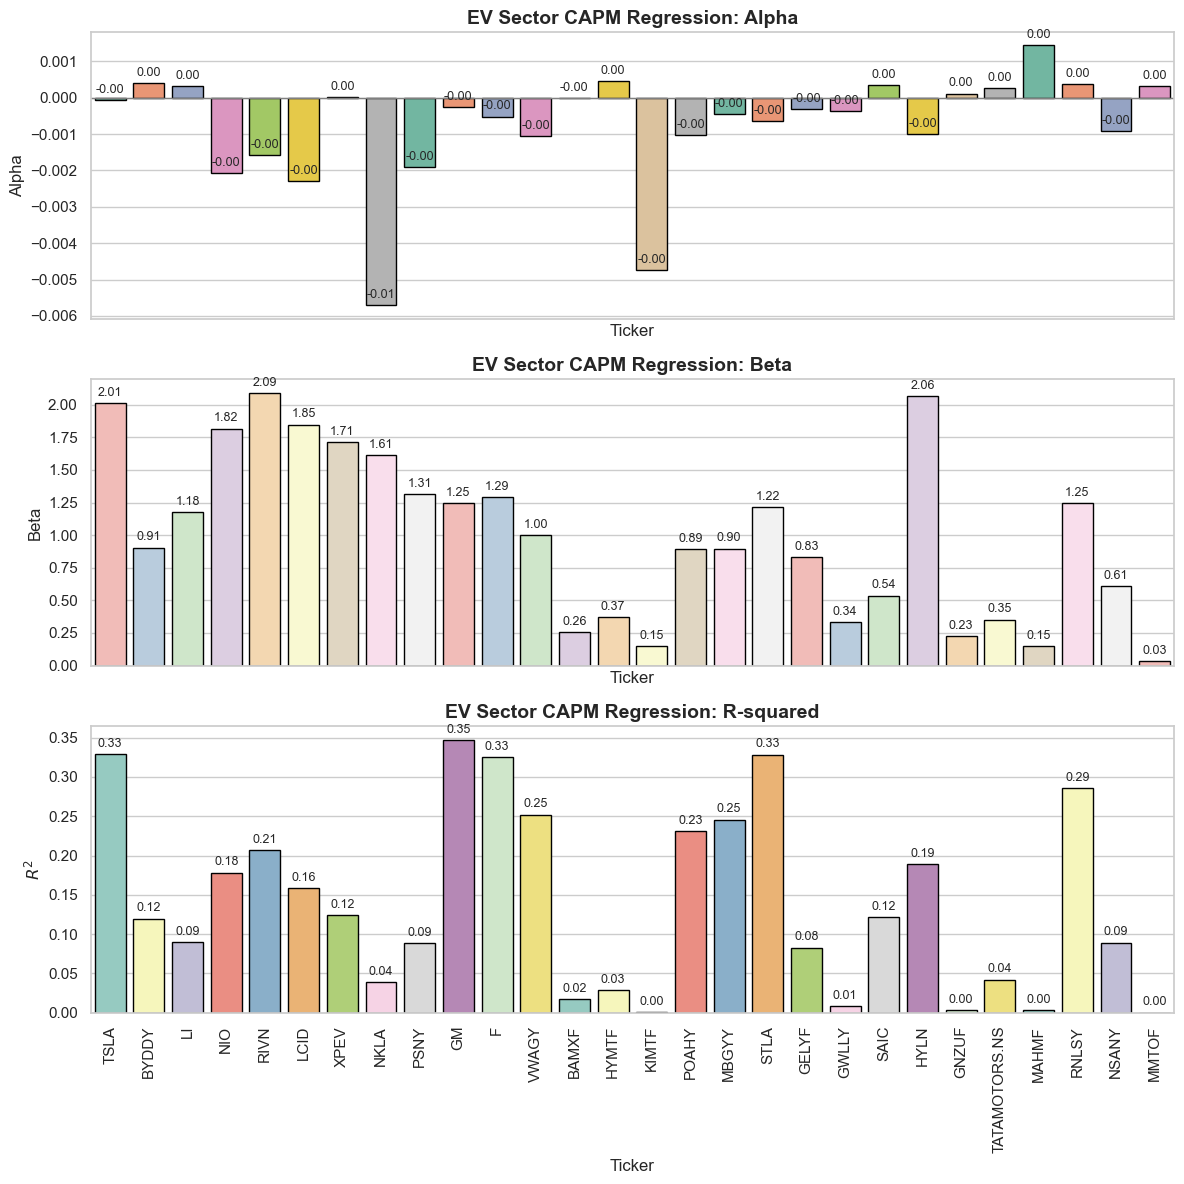

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Suppose ev_capm is your DataFrame with columns: alpha, beta, R2
# Convert the index to a "Ticker" column for plotting
ev_capm_plot = ev_capm.reset_index().rename(columns={'index': 'Ticker'})

# Use a nice Seaborn theme
sns.set_theme(style="whitegrid")

# Create a figure with 3 subplots (alpha, beta, R²)
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 12), sharex=True)

# 1) ALPHA
sns.barplot(data=ev_capm_plot, x='Ticker', y='alpha', ax=axs[0], palette="Set2", edgecolor="black")
axs[0].axhline(0, color="gray", linewidth=1)  # zero reference line
axs[0].set_title("EV Sector CAPM Regression: Alpha", fontsize=14, fontweight="bold")
axs[0].set_ylabel("Alpha", fontsize=12)
# Annotate bars with alpha values
for p in axs[0].patches:
    height = p.get_height()
    axs[0].annotate(f"{height:.2f}",
                    (p.get_x() + p.get_width() / 2., height),
                    ha="center", va="bottom", fontsize=9,
                    xytext=(0, 3), textcoords="offset points")

# 2) BETA
sns.barplot(data=ev_capm_plot, x='Ticker', y='beta', ax=axs[1], palette="Pastel1", edgecolor="black")
axs[1].axhline(0, color="gray", linewidth=1)  # zero reference line
axs[1].set_title("EV Sector CAPM Regression: Beta", fontsize=14, fontweight="bold")
axs[1].set_ylabel("Beta", fontsize=12)
# Annotate bars with beta values
for p in axs[1].patches:
    height = p.get_height()
    axs[1].annotate(f"{height:.2f}",
                    (p.get_x() + p.get_width() / 2., height),
                    ha="center", va="bottom", fontsize=9,
                    xytext=(0, 3), textcoords="offset points")

# 3) R²
sns.barplot(data=ev_capm_plot, x='Ticker', y='R2', ax=axs[2], palette="Set3", edgecolor="black")
axs[2].set_title("EV Sector CAPM Regression: R-squared", fontsize=14, fontweight="bold")
axs[2].set_ylabel("$R^2$", fontsize=12)
axs[2].set_xlabel("Ticker", fontsize=12)
# Annotate bars with R² values
for p in axs[2].patches:
    height = p.get_height()
    axs[2].annotate(f"{height:.2f}",
                    (p.get_x() + p.get_width() / 2., height),
                    ha="center", va="bottom", fontsize=9,
                    xytext=(0, 3), textcoords="offset points")

# Rotate x-tick labels on the bottom subplot (and hide them on top subplots if desired)
plt.setp(axs[0].get_xticklabels(), visible=False)
plt.setp(axs[1].get_xticklabels(), visible=False)
plt.setp(axs[2].get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()


In [34]:
# 3. Run Fama–French 3-Factor regression (using dummy FF factor data, e.g., ff_data)
ev_ff = run_fama_french_3factor(ev_returns, ff_data)
print("\n=== EV Sector Fama–French 3-Factor Regression ===")
print(ev_ff)


=== EV Sector Fama–French 3-Factor Regression ===
                  alpha     b_MKT     b_SMB     b_HML        R2
TSLA           0.000495  0.000079  0.001861  0.000420  0.002362
BYDDY          0.000796 -0.000382  0.000561 -0.000525  0.000722
LI             0.000774 -0.000114  0.001387  0.000346  0.001109
NIO           -0.001471 -0.000836  0.000789  0.000941  0.000979
RIVN          -0.000829 -0.002625  0.003436  0.000531  0.006979
LCID          -0.001552 -0.003488  0.002363 -0.000484  0.006060
XPEV           0.000534  0.000654  0.000531  0.001627  0.001073
NKLA          -0.005074  0.000017  0.000698  0.005137  0.003102
PSNY          -0.001411  0.000189  0.000494  0.001950  0.001585
GM             0.000176  0.000094  0.001054 -0.000272  0.001899
F              0.000017 -0.001544  0.001378 -0.000484  0.005511
VWAGY         -0.000581 -0.001037  0.001019 -0.000257  0.003469
BAMXF          0.000291 -0.000424  0.000524 -0.000464  0.001014
HYMTF          0.000828 -0.000753  0.000337  0.000238

In [35]:
import statsmodels.api as sm

# Loop over each EV ticker and run Fama–French 3-Factor regression
for ticker in ev_returns.columns:
    # Find common dates between the asset returns and the FF factor data
    common_dates = ev_returns[ticker].index.intersection(ff_data.index)
    
    # Extract the asset's return series (assumed to be excess returns) and the FF factors
    y = ev_returns[ticker].loc[common_dates]
    X = ff_data.loc[common_dates, ['MKT', 'SMB', 'HML']]
    
    # Add a constant (intercept)
    X = sm.add_constant(X)
    
    # Fit the OLS regression model
    model = sm.OLS(y, X).fit()
    
    # Print the full summary for the current ticker
    print(f"\n=== Fama–French 3-Factor Regression Summary for {ticker} ===")
    print(model.summary())



=== Fama–French 3-Factor Regression Summary for TSLA ===
                            OLS Regression Results                            
Dep. Variable:                   TSLA   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7261
Date:                Tue, 08 Apr 2025   Prob (F-statistic):              0.537
Time:                        16:13:31   Log-Likelihood:                 1551.5
No. Observations:                 854   AIC:                            -3095.
Df Residuals:                     850   BIC:                            -3076.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

                            OLS Regression Results                            
Dep. Variable:                   NKLA   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9787
Date:                Tue, 08 Apr 2025   Prob (F-statistic):              0.402
Time:                        16:13:32   Log-Likelihood:                 826.24
No. Observations:                 854   AIC:                            -1644.
Df Residuals:                     850   BIC:                            -1625.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0054      0.003     -1.694      0.0


=== Fama–French 3-Factor Regression Summary for MBGYY ===
                            OLS Regression Results                            
Dep. Variable:                  MBGYY   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6082
Date:                Tue, 08 Apr 2025   Prob (F-statistic):              0.610
Time:                        16:13:32   Log-Likelihood:                 2117.0
No. Observations:                 854   AIC:                            -4226.
Df Residuals:                     850   BIC:                            -4207.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------


=== Fama–French 3-Factor Regression Summary for RNLSY ===
                            OLS Regression Results                            
Dep. Variable:                  RNLSY   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.641
Date:                Tue, 08 Apr 2025   Prob (F-statistic):              0.178
Time:                        16:13:32   Log-Likelihood:                 1902.7
No. Observations:                 854   AIC:                            -3797.
Df Residuals:                     850   BIC:                            -3778.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

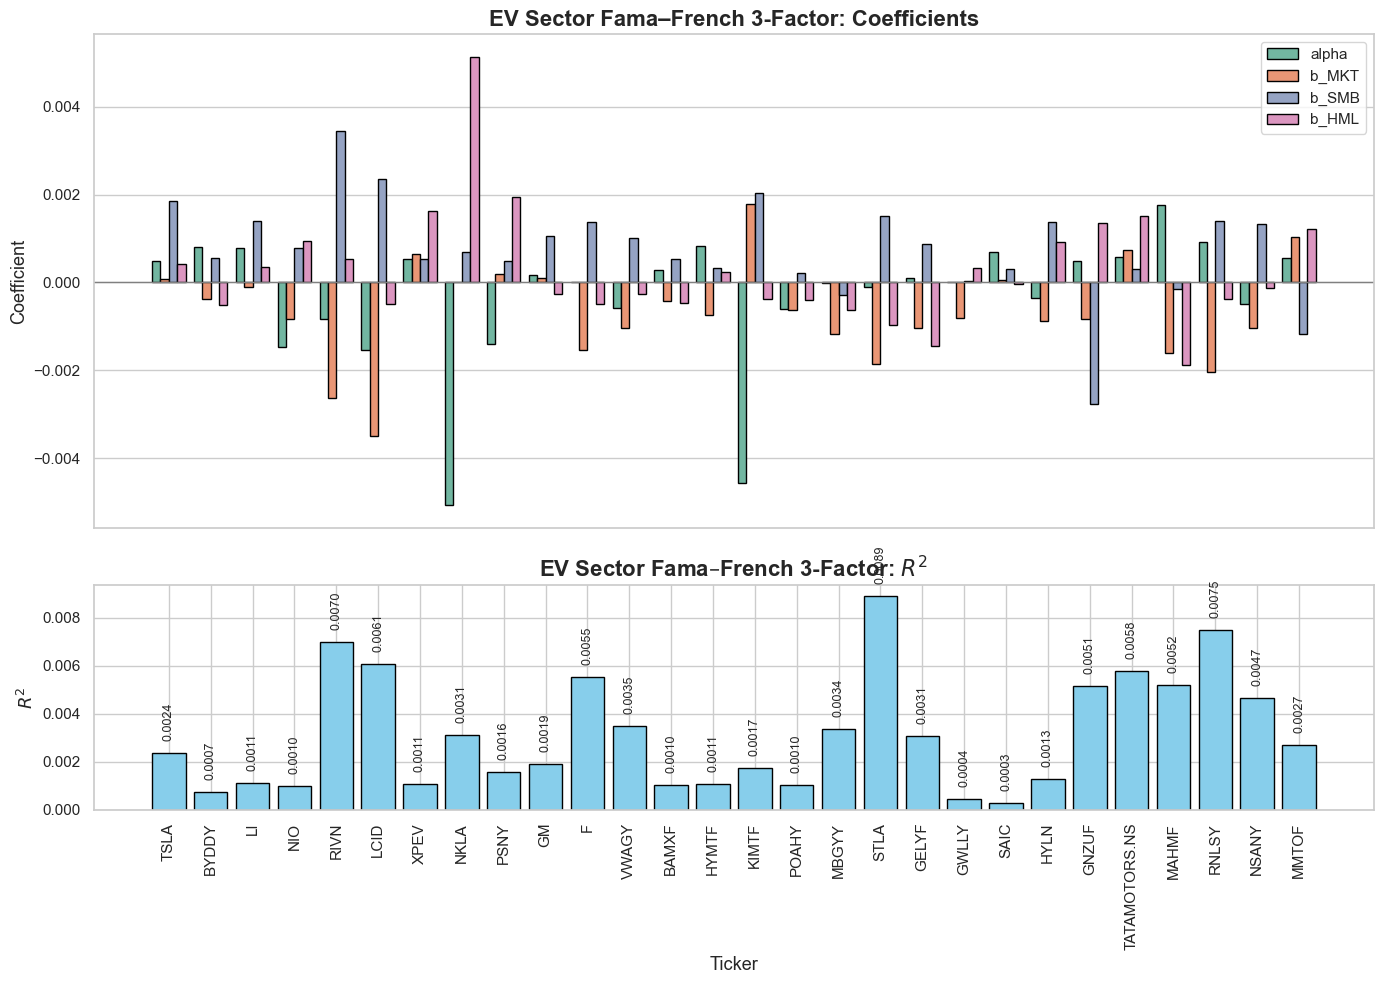

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Suppose ev_ff is a DataFrame with columns ["alpha","b_MKT","b_SMB","b_HML","R2"].
# Its index are tickers, e.g. ["TSLA","BYDDY","NIO","RIVN",...].

# 1. Separate the factor loadings (coefficients) from the R²
ff_coeffs = ev_ff[["alpha", "b_MKT", "b_SMB", "b_HML"]]
tickers = ff_coeffs.index

# 2. Convert the factor loadings into a "long" format for grouped bar plotting
ff_melted = ff_coeffs.reset_index().melt(
    id_vars="index",
    var_name="Factor",
    value_name="Coefficient"
)

# 3. Set a Seaborn style/theme
sns.set_theme(style="whitegrid")

# 4. Create a 2-row subplot: top for factor loadings, bottom for R²
fig, axes = plt.subplots(
    nrows=2, ncols=1, 
    figsize=(14, 10), 
    sharex=True,
    gridspec_kw={"height_ratios": [2.2, 1]}
)

# --- TOP PANEL: Factor Loadings ---
sns.barplot(
    x="index", 
    y="Coefficient", 
    hue="Factor", 
    data=ff_melted, 
    ax=axes[0],
    palette="Set2",
    edgecolor="black"
)
axes[0].axhline(0, color="gray", linewidth=1)  # zero reference line
axes[0].set_title("EV Sector Fama–French 3-Factor: Coefficients", fontsize=16, fontweight="bold")
axes[0].set_xlabel("")
axes[0].set_ylabel("Coefficient", fontsize=13)
axes[0].legend(loc="upper right", frameon=True)
axes[0].tick_params(axis="x", rotation=90)

# --- BOTTOM PANEL: R² ---
axes[1].bar(tickers, ev_ff["R2"], color="skyblue", edgecolor="black")
axes[1].set_title("EV Sector Fama–French 3-Factor: $R^2$", fontsize=16, fontweight="bold")
axes[1].set_xlabel("Ticker", fontsize=13)
axes[1].set_ylabel("$R^2$", fontsize=13)
axes[1].set_ylim(0, 1.05 * ev_ff["R2"].max())  # add some headroom

# Label each R² bar on top
for i, val in enumerate(ev_ff["R2"]):
    axes[1].text(
        i, val + 0.0005, f"{val:.4f}",
        ha="center", va="bottom", rotation=90, fontsize=9
    )

axes[1].tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.show()


In [37]:
# 4. Fit AR(1) models for each EV ticker (print overall summary table)
ev_ar = fit_ar1_model(ev_returns)
print("\n=== EV Sector AR(1) Model Coefficients (one row per ticker) ===")
print(ev_ar)


=== EV Sector AR(1) Model Coefficients (one row per ticker) ===
               intercept  phi          AIC          BIC
TSLA            0.000218  NaN -3234.360019 -3220.006648
BYDDY           0.000473  NaN -3754.457651 -3740.104280
LI              0.000440  NaN -3036.881280 -3022.527909
NIO            -0.001855  NaN -2875.482457 -2861.129086
RIVN           -0.001459  NaN -2779.401928 -2765.048557
LCID           -0.002145  NaN -2748.448374 -2734.095003
XPEV            0.000183  NaN -2665.139070 -2650.785699
NKLA           -0.005898  NaN -1742.087263 -1727.733892
PSNY           -0.001665  NaN -2830.116312 -2815.762941
GM             -0.000121  NaN -4133.321867 -4118.968496
F              -0.000328  NaN -4007.887014 -3993.533643
VWAGY          -0.000856  NaN -4235.542043 -4221.188672
BAMXF           0.000020  NaN -4239.101129 -4224.747758
HYMTF           0.000564  NaN -4103.050379 -4088.697008
KIMTF          -0.004578  NaN -2248.517510 -2234.164139
POAHY          -0.000763  NaN -4371.045

C:\Users\haloi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\haloi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\haloi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\haloi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

Index(['Ticker', 'intercept', 'phi', 'AIC', 'BIC'], dtype='object')


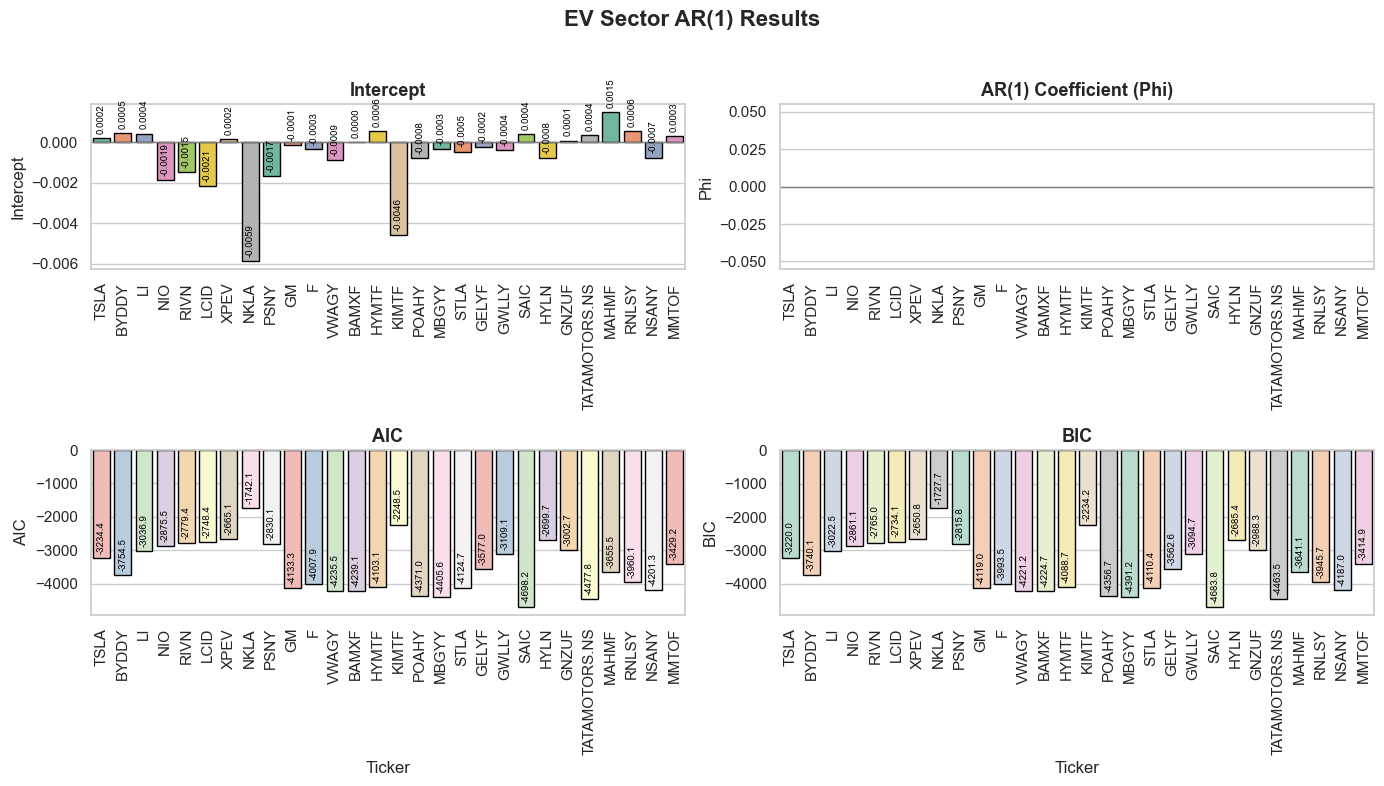

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Suppose ev_ar is the DataFrame from fit_ar1_model(ev_returns),
# with columns: [intercept, phi, AIC, BIC] (or whichever names you have).
# If your AR(1) coefficient is stored as "y.L1" or "L1.y", rename it to "phi" first.
# ev_ar = ev_ar.rename(columns={"y.L1": "phi"})  # Example rename if needed

# Convert index to a column for plotting
ev_ar_plot = ev_ar.reset_index().rename(columns={'index': 'Ticker'})

# Ensure 'phi' actually exists in your DataFrame
print(ev_ar_plot.columns)  # Debug

# Use a consistent style
sns.set_theme(style="whitegrid", font_scale=1.0)

# Create a 2×2 grid
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle("EV Sector AR(1) Results", fontsize=16, fontweight="bold")

# --- (1) Intercept ---
sns.barplot(data=ev_ar_plot, x='Ticker', y='intercept', ax=axs[0, 0],
            palette="Set2", edgecolor="black")
axs[0, 0].axhline(0, color="gray", linewidth=1)
axs[0, 0].set_title("Intercept", fontsize=13, fontweight="bold")
axs[0, 0].set_ylabel("Intercept")
axs[0, 0].set_xlabel("")
# Annotate the bars (vertical text, smaller font)
for p in axs[0, 0].patches:
    height = p.get_height()
    axs[0, 0].annotate(f"{height:.4f}",
                       (p.get_x() + p.get_width() / 2., height),
                       ha="center", va="bottom",
                       rotation=90,            # rotate text vertically
                       xytext=(0, 3),         # offset above the bar
                       textcoords="offset points",
                       fontsize=7,            # smaller font
                       color="black")

# --- (2) Phi (AR(1) coefficient) ---
sns.barplot(data=ev_ar_plot, x='Ticker', y='phi', ax=axs[0, 1],
            palette="Set3", edgecolor="black")
axs[0, 1].axhline(0, color="gray", linewidth=1)
axs[0, 1].set_title("AR(1) Coefficient (Phi)", fontsize=13, fontweight="bold")
axs[0, 1].set_ylabel("Phi")
axs[0, 1].set_xlabel("")
for p in axs[0, 1].patches:
    height = p.get_height()
    axs[0, 1].annotate(f"{height:.4f}",
                       (p.get_x() + p.get_width() / 2., height),
                       ha="center", va="bottom",
                       rotation=90,
                       xytext=(0, 3),
                       textcoords="offset points",
                       fontsize=7,
                       color="black")

# --- (3) AIC ---
sns.barplot(data=ev_ar_plot, x='Ticker', y='AIC', ax=axs[1, 0],
            palette="Pastel1", edgecolor="black")
axs[1, 0].set_title("AIC", fontsize=13, fontweight="bold")
axs[1, 0].set_ylabel("AIC")
axs[1, 0].set_xlabel("Ticker")
for p in axs[1, 0].patches:
    height = p.get_height()
    axs[1, 0].annotate(f"{height:.1f}",
                       (p.get_x() + p.get_width() / 2., height),
                       ha="center", va="bottom",
                       rotation=90,
                       xytext=(0, 3),
                       textcoords="offset points",
                       fontsize=7,
                       color="black")

# --- (4) BIC ---
sns.barplot(data=ev_ar_plot, x='Ticker', y='BIC', ax=axs[1, 1],
            palette="Pastel2", edgecolor="black")
axs[1, 1].set_title("BIC", fontsize=13, fontweight="bold")
axs[1, 1].set_ylabel("BIC")
axs[1, 1].set_xlabel("Ticker")
for p in axs[1, 1].patches:
    height = p.get_height()
    axs[1, 1].annotate(f"{height:.1f}",
                       (p.get_x() + p.get_width() / 2., height),
                       ha="center", va="bottom",
                       rotation=90,
                       xytext=(0, 3),
                       textcoords="offset points",
                       fontsize=7,
                       color="black")

# Rotate ticker labels on x-axis
for ax in axs.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.show()


In [39]:
# 5. Forecasting:
forecast_steps = 10  # Forecast horizon (business days)
ev_forecasts = {}    # Dictionary to store forecasts per ticker

for ticker in ev_returns.columns:
    ts = ev_returns[ticker].dropna()
    if len(ts) < 30:
        continue  # Skip if not enough data
    try:
        model = AutoReg(ts, lags=1, old_names=False).fit()
        # Forecast next forecast_steps periods
        fc = model.predict(start=len(ts), end=len(ts)+forecast_steps-1)
        ev_forecasts[ticker] = (ts, fc)
    except Exception as e:
        print(f"Could not forecast {ticker}: {e}")

C:\Users\haloi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\haloi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\haloi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\haloi\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will co

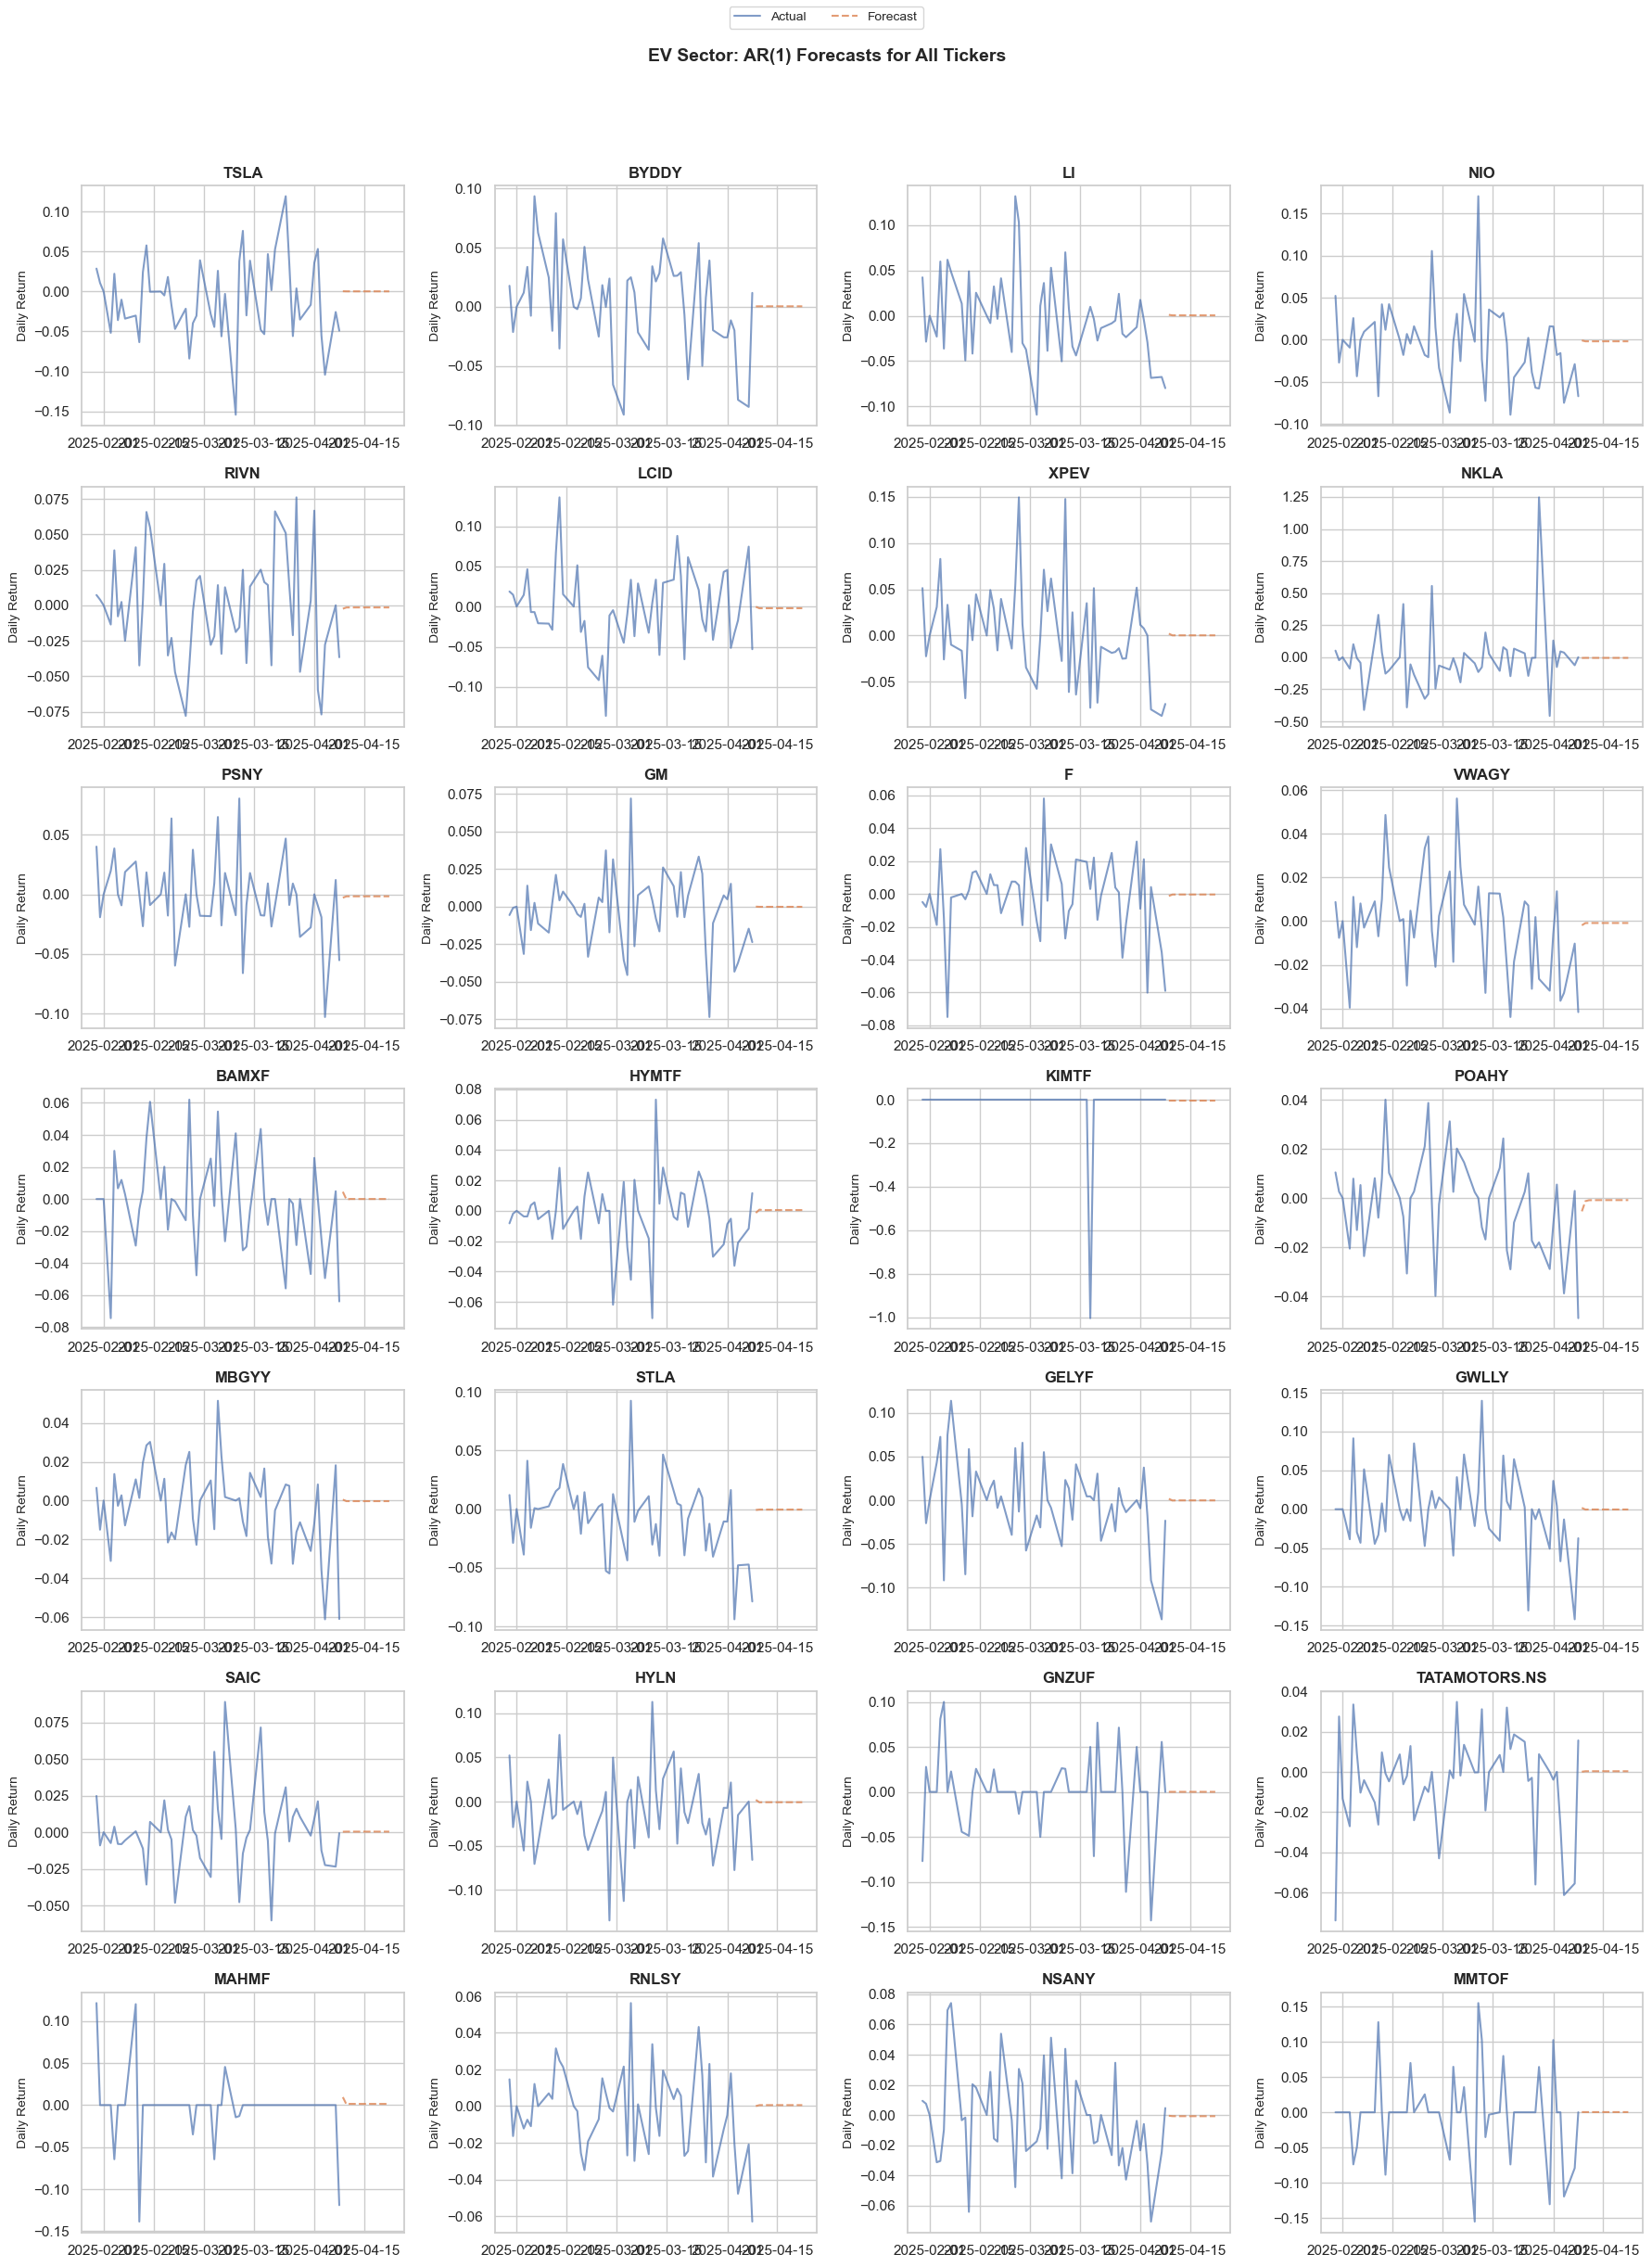

In [40]:
import math
import pandas as pd
import matplotlib.pyplot as plt

# ev_forecasts: dict[ticker -> (actual_series, forecast_series)]
# forecast_steps: int, how many forecast days

num_tickers = len(ev_forecasts)
ncols = 4  # You can change this to 3, 5, etc. depending on how many subplots per row you want
nrows = math.ceil(num_tickers / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, 
                         figsize=(4.5*ncols, 3.5*nrows), 
                         sharex=False, sharey=False)
axes = axes.flatten()  # Flatten so we can iterate easily

for i, (ticker, (ts, fc)) in enumerate(ev_forecasts.items()):
    ax = axes[i]
    
    # Plot last 50 actual returns (or whatever slice you prefer)
    ax.plot(ts.index[-50:], ts[-50:], label="Actual", alpha=0.7)
    
    # Create future date range for forecast
    future_dates = pd.date_range(
        start=ts.index[-1], periods=forecast_steps + 1, freq='B'
    )[1:]  # skip the first day because it's the last actual day
    
    # Plot the forecast
    ax.plot(future_dates, fc, linestyle="--", label="Forecast", alpha=0.8)
    
    # Customize subplot
    ax.set_title(ticker, fontsize=12, fontweight="bold")
    ax.set_xlabel("")
    ax.set_ylabel("Daily Return", fontsize=10)
    ax.grid(True)

# If we have unused axes (when # tickers < nrows*ncols), hide them
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Create an overall legend (pull from the first axes that actually has lines)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, fontsize=10)

# Add an overall title
fig.suptitle("EV Sector: AR(1) Forecasts for All Tickers", fontsize=14, fontweight="bold")

# Tweak layout to make room for the suptitle
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [41]:
capm_ev = run_capm_regression(ev_returns, market_data, rf=0)

AttributeError: 'DataFrame' object has no attribute 'name'

In [42]:
## Robin Section

In [43]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

warnings.filterwarnings("ignore")  # Ignore warnings for clean output

# Function to run ARIMAX for each ticker
def run_arimax_analysis(returns_df, market_returns, arimax_order=(1, 1, 1)):
    """
    Run ARIMAX model on each ticker's returns using market returns as exogenous variable.
    
    """
    results = []

    # Align market returns with ticker returns
    common_index = returns_df.index.intersection(market_returns.index)
    returns_df = returns_df.loc[common_index]
    market_returns = market_returns.loc[common_index]

    for ticker in returns_df.columns:
        try:
            # Separate endogenous and exogenous variables
            endog = returns_df[ticker]
            exog = market_returns
            
            # Split into train and test sets (80-20 split)
            train_size = int(0.8 * len(endog))
            endog_train, endog_test = endog[:train_size], endog[train_size:]
            exog_train, exog_test = exog[:train_size], exog[train_size:]
            
            # Fit ARIMAX model
            model = SARIMAX(endog_train, exog=exog_train, order=arimax_order, 
                            enforce_stationarity=False, enforce_invertibility=False)
            result = model.fit(disp=False)
            
            # Forecast
            forecast = result.forecast(steps=len(endog_test), exog=exog_test)
            
            # Evaluate performance
            mae = mean_absolute_error(endog_test, forecast)
            mse = mean_squared_error(endog_test, forecast)
            rmse = np.sqrt(mse)
            aic = result.aic
            
            # Append results
            results.append({"Ticker": ticker, "MAE": mae, "MSE": mse, "RMSE": rmse, "AIC": aic})
        
        except Exception as e:
            print(f"Error processing ticker {ticker}: {e}")
            continue

    # Return results as DataFrame
    return pd.DataFrame(results)


In [44]:
ev_arimax_results = run_arimax_analysis(ev_returns, market_returns, arimax_order=(1, 1, 1))
print("\nEV Sector ARIMAX Results:")
print(ev_arimax_results)



EV Sector ARIMAX Results:
           Ticker       MAE       MSE      RMSE          AIC
0            TSLA  0.025891  0.001329  0.036454 -2770.567598
1           BYDDY  0.021777  0.000903  0.030044 -2970.907144
2              LI  0.031525  0.001821  0.042679 -2370.529511
3             NIO  0.033467  0.002129  0.046138 -2327.154647
4            RIVN  0.029132  0.001823  0.042699 -2250.172620
5            LCID  0.032664  0.001997  0.044686 -2178.630188
6            XPEV  0.040278  0.002631  0.051296 -2104.539142
7            NKLA  0.081647  0.023212  0.152354 -1741.200440
8            PSNY  0.040828  0.002965  0.054450 -2262.023721
9              GM  0.014855  0.000502  0.022406 -3504.222451
10              F  0.013777  0.000392  0.019810 -3296.371210
11          VWAGY  0.015434  0.000384  0.019607 -3420.855945
12          BAMXF  0.018810  0.000703  0.026510 -3316.362440
13          HYMTF  0.019181  0.000669  0.025865 -3181.300958
14          KIMTF  0.010300  0.005863  0.076569 -1736.4690

In [45]:
tech_arimax_results = run_arimax_analysis(tech_returns, market_returns, arimax_order=(1, 1, 1))
print("\nTech Sector ARIMAX Results:")
print(tech_arimax_results)


Tech Sector ARIMAX Results:
   Ticker       MAE       MSE      RMSE          AIC
0    AAPL  0.009730  0.000180  0.013419 -5612.156994
1    MSFT  0.006852  0.000106  0.010300 -5696.369241
2   GOOGL  0.010123  0.000199  0.014120 -5238.808406
3    GOOG  0.009992  0.000192  0.013860 -5242.997703
4    AMZN  0.010113  0.000179  0.013367 -4931.090468
5    META  0.011713  0.000239  0.015467 -4279.309360
6    NVDA  0.020017  0.000737  0.027153 -4246.327831
7     TSM  0.016777  0.000527  0.022949 -4780.929834
8    ADBE  0.012248  0.000447  0.021142 -4908.807491
9    INTC  0.021608  0.001150  0.033916 -4623.506046
10   CSCO  0.007095  0.000105  0.010244 -5588.143076
11   ORCL  0.013076  0.000451  0.021228 -5003.061303
12    IBM  0.009150  0.000218  0.014767 -5348.713643
13    CRM  0.011955  0.000434  0.020825 -4879.150441
14   QCOM  0.012708  0.000304  0.017442 -4797.378448
15   AVGO  0.020350  0.001038  0.032211 -5129.459680
16    TXN  0.011182  0.000240  0.015495 -5545.142309
17    AMD  0.0168

In [46]:
finbank_arimax_results = run_arimax_analysis(finbank_returns, market_returns, arimax_order=(1, 1, 1))

print("\nFinancial/Banking Sector ARIMAX Results:")
print(finbank_arimax_results)


Financial/Banking Sector ARIMAX Results:
   Ticker       MAE       MSE      RMSE          AIC
0     JPM  0.008841  0.000161  0.012680 -8479.480046
1     BAC  0.010153  0.000192  0.013839 -8152.004232
2     WFC  0.011412  0.000257  0.016024 -7734.823828
3       C  0.010519  0.000207  0.014389 -7872.362574
4      GS  0.009311  0.000177  0.013288 -8449.492840
5      MS  0.010213  0.000204  0.014277 -8385.890577
6     USB  0.011257  0.000225  0.014988 -7830.426564
7     PNC  0.010465  0.000195  0.013970 -8102.346798
8     TFC  0.011086  0.000226  0.015022 -7515.329118
9     COF  0.012164  0.000302  0.017379 -7496.772881
10     TD  0.007990  0.000131  0.011446 -9058.711620
11   SCHW  0.010841  0.000258  0.016077 -7456.989910
12     BK  0.007876  0.000114  0.010694 -8212.384047
13    STT  0.008971  0.000152  0.012332 -7677.872526
14    AXP  0.008835  0.000152  0.012336 -8010.867999
15   HSBC  0.008805  0.000160  0.012665 -8149.731743
16    CFG  0.013160  0.000329  0.018144 -7181.439244
17  

In [48]:
def run_arimax_regression(sector_returns, market_returns, arimax_order=(1, 1, 1)):
    """
    Run ARIMAX regression for any sector's returns using market returns as the exogenous variable.
    """ 
    results = []

    # Align the data to ensure consistent index
    common_index = sector_returns.index.intersection(market_returns.index)
    sector_returns = sector_returns.loc[common_index]
    market_returns = market_returns.loc[common_index]

    for ticker in sector_returns.columns:
        try:
            # Separate endogenous (sector returns) and exogenous (market returns) variables
            endog = sector_returns[ticker]
            exog = market_returns

            # Split the data into training (80%) and testing (20%)
            train_size = int(len(endog) * 0.8)
            endog_train, endog_test = endog[:train_size], endog[train_size:]
            exog_train, exog_test = exog[:train_size], exog[train_size:]

            # Fit ARIMAX model
            model = SARIMAX(endog_train, exog=exog_train, order=arimax_order, 
                            enforce_stationarity=False, enforce_invertibility=False)
            result = model.fit(disp=False)

            # Forecast using the test set
            forecast = result.forecast(steps=len(endog_test), exog=exog_test)

            # Evaluate performance
            mae = mean_absolute_error(endog_test, forecast)
            mse = mean_squared_error(endog_test, forecast)
            rmse = np.sqrt(mse)
            aic = result.aic

            # Extract the coefficient of the exogenous variable (e.g., market returns)
            exog_impact = result.params.get('x1', np.nan)  # Coefficient of market returns

            # Append results
            results.append({
                "Ticker": ticker,
                "MAE": mae,
                "MSE": mse,
                "RMSE": rmse,
                "AIC": aic,
                "Exogenous Impact": exog_impact
            })
        
        except Exception as e:
            print(f"Error processing ticker {ticker}: {e}")
            continue

    # Return results as a DataFrame
    return pd.DataFrame(results)


In [49]:
# Run for EV sector
ev_arimax_results = run_arimax_regression(ev_returns, market_returns, arimax_order=(1, 1, 1))
print("EV Sector ARIMAX Regression Results:")
print(ev_arimax_results)

EV Sector ARIMAX Regression Results:
           Ticker       MAE       MSE      RMSE          AIC  Exogenous Impact
0            TSLA  0.025891  0.001329  0.036454 -2770.567598               NaN
1           BYDDY  0.021777  0.000903  0.030044 -2970.907144               NaN
2              LI  0.031525  0.001821  0.042679 -2370.529511               NaN
3             NIO  0.033467  0.002129  0.046138 -2327.154647               NaN
4            RIVN  0.029132  0.001823  0.042699 -2250.172620               NaN
5            LCID  0.032664  0.001997  0.044686 -2178.630188               NaN
6            XPEV  0.040278  0.002631  0.051296 -2104.539142               NaN
7            NKLA  0.081647  0.023212  0.152354 -1741.200440               NaN
8            PSNY  0.040828  0.002965  0.054450 -2262.023721               NaN
9              GM  0.014855  0.000502  0.022406 -3504.222451               NaN
10              F  0.013777  0.000392  0.019810 -3296.371210               NaN
11          VWA

In [50]:
# Specify ARIMAX order
arimax_order = (1, 1, 1)  # (p, d, q)

# Loop through each ticker in the sector
for ticker in ev_returns.columns:
    # Align the dates between the ticker's returns and market returns
    common_dates = ev_returns[ticker].index.intersection(market_returns.index)
    y = ev_returns[ticker].loc[common_dates]  # Endogenous variable (ticker returns)
    X = market_returns.loc[common_dates]     # Exogenous variable (market returns)
    
    try:
        # Fit the ARIMAX model
        model = SARIMAX(y, exog=X, order=arimax_order, 
                        enforce_stationarity=False, enforce_invertibility=False)
        result = model.fit(disp=False)
        
        # Print the ARIMAX regression summary for the ticker
        print(f"\n=== ARIMAX Regression Summary for {ticker} ===")
        print(result.summary())
    
    except Exception as e:
        print(f"Error processing ticker {ticker}: {e}")


=== ARIMAX Regression Summary for TSLA ===
                               SARIMAX Results                                
Dep. Variable:                   TSLA   No. Observations:                  854
Model:               SARIMAX(1, 1, 1)   Log Likelihood                1710.779
Date:                Tue, 08 Apr 2025   AIC                          -3413.557
Time:                        16:16:51   BIC                          -3394.572
Sample:                             0   HQIC                         -3406.285
                                - 854                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
^GSPC          2.0204      0.095     21.305      0.000       1.835       2.206
ar.L1          0.0380      0.032      1.172      0.241      -0.026       0.101
ma.L1   


=== ARIMAX Regression Summary for LCID ===
                               SARIMAX Results                                
Dep. Variable:                   LCID   No. Observations:                  854
Model:               SARIMAX(1, 1, 1)   Log Likelihood                1380.634
Date:                Tue, 08 Apr 2025   AIC                          -2753.269
Time:                        16:16:56   BIC                          -2734.283
Sample:                             0   HQIC                         -2745.997
                                - 854                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
^GSPC          1.8446      0.153     12.075      0.000       1.545       2.144
ar.L1         -0.0176      0.027     -0.651      0.515      -0.071       0.035
ma.L1   


=== ARIMAX Regression Summary for F ===
                               SARIMAX Results                                
Dep. Variable:                      F   No. Observations:                  854
Model:               SARIMAX(1, 1, 1)   Log Likelihood                2081.421
Date:                Tue, 08 Apr 2025   AIC                          -4154.843
Time:                        16:17:01   BIC                          -4135.857
Sample:                             0   HQIC                         -4147.571
                                - 854                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
^GSPC          1.2998      0.055     23.619      0.000       1.192       1.408
ar.L1         -0.0423      0.033     -1.280      0.201      -0.107       0.022
ma.L1      


=== ARIMAX Regression Summary for POAHY ===
                               SARIMAX Results                                
Dep. Variable:                  POAHY   No. Observations:                  854
Model:               SARIMAX(1, 1, 1)   Log Likelihood                2202.066
Date:                Tue, 08 Apr 2025   AIC                          -4396.131
Time:                        16:17:06   BIC                          -4377.146
Sample:                             0   HQIC                         -4388.859
                                - 854                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
^GSPC          0.8929      0.047     18.948      0.000       0.800       0.985
ar.L1          0.1230      0.025      4.842      0.000       0.073       0.173
ma.L1  


=== ARIMAX Regression Summary for SAIC ===
                               SARIMAX Results                                
Dep. Variable:                   SAIC   No. Observations:                  854
Model:               SARIMAX(1, 1, 1)   Log Likelihood                2300.237
Date:                Tue, 08 Apr 2025   AIC                          -4592.475
Time:                        16:17:13   BIC                          -4573.489
Sample:                             0   HQIC                         -4585.203
                                - 854                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
^GSPC          0.5356      0.058      9.255      0.000       0.422       0.649
ar.L1          0.0528      0.028      1.859      0.063      -0.003       0.108
ma.L1   


=== ARIMAX Regression Summary for RNLSY ===
                               SARIMAX Results                                
Dep. Variable:                  RNLSY   No. Observations:                  854
Model:               SARIMAX(1, 1, 1)   Log Likelihood                2036.193
Date:                Tue, 08 Apr 2025   AIC                          -4064.385
Time:                        16:17:18   BIC                          -4045.400
Sample:                             0   HQIC                         -4057.113
                                - 854                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
^GSPC          1.2534      0.055     22.789      0.000       1.146       1.361
ar.L1          0.0675      0.031      2.181      0.029       0.007       0.128
ma.L1  

In [51]:
# Define ARIMAX modeling function
def fit_arimax(endog, exog, order=(1, 1, 1)):
    """
    Fits an ARIMAX model to the data.
    
    """
    model = SARIMAX(endog, exog=exog, order=order, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit(disp=False)
    return result
sector_returns = tech_returns.mean(axis=1)  # Combine individual returns into a single series
exogenous_variable = market_returns  # S&P 500 returns



Mean Absolute Error (MAE): 0.0049
Mean Squared Error (MSE): 0.0000
Root Mean Squared Error (RMSE): 0.0066


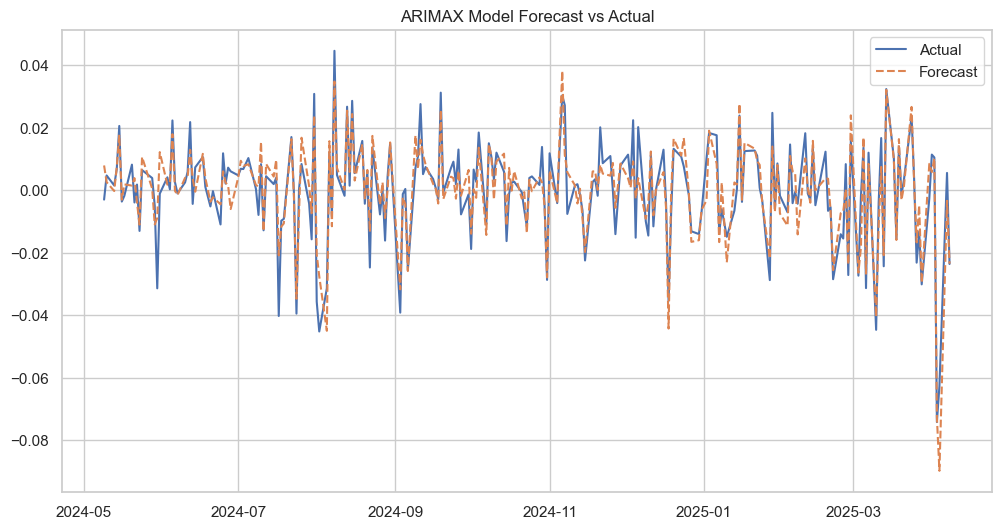

In [52]:
# Align the data
sector_returns, exogenous_variable = sector_returns.align(exogenous_variable, join='inner')

# Split into training and testing sets
train_size = int(0.8 * len(sector_returns))
endog_train, endog_test = sector_returns[:train_size], sector_returns[train_size:]
exog_train, exog_test = exogenous_variable[:train_size], exogenous_variable[train_size:]

#Fit ARIMAX model
arimax_order = (1, 1, 1)  # Example (p, d, q) order
arimax_model = fit_arimax(endog_train, exog_train, order=arimax_order)

# Forecast and evaluate
forecast = arimax_model.forecast(steps=len(endog_test), exog=exog_test)

# Evaluate performance
mae = mean_absolute_error(endog_test, forecast)
mse = mean_squared_error(endog_test, forecast)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

#Plot results
plt.figure(figsize=(12, 6))
plt.plot(endog_test.index, endog_test, label="Actual")
plt.plot(endog_test.index, forecast, label="Forecast", linestyle="--")
plt.title("ARIMAX Model Forecast vs Actual")
plt.legend()
plt.show()